In [1]:
%matplotlib inline 

# 1) Wipe out your namespace
%reset -f

# 2) Clear Jupyter’s stored outputs (and inputs if you like)
try:
    Out.clear()
except NameError:
    pass

try:
    In.clear()
except NameError:
    pass

# 3) Force Python GC
import gc
gc.collect()

# 4) Free any GPU buffers
import torch
if torch.cuda.is_available():
    torch.cuda.empty_cache()

import importlib
from libs import params, trades, feats, plots, models_core, models_custom
importlib.reload(params)
importlib.reload(trades)
importlib.reload(feats)
importlib.reload(plots)
importlib.reload(models_core)
importlib.reload(models_custom)

<module 'libs.models_custom' from '/workspace/my_models/Trading/_Stock_Analysis_/libs/models_custom.py'>

In [2]:
import pandas as pd
pd.set_option('display.max_columns', None)

import numpy  as np
import math
import matplotlib.pyplot as plt
import seaborn as sns

import datetime as dt
import os
from typing import Sequence, List, Tuple, Optional, Union
from pathlib import Path
import time
import io
import contextlib

import torch
import torch.nn as nn
from torch.nn import MSELoss, Dropout
import torch.nn.functional as Funct
from torch_lr_finder import LRFinder
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, ReduceLROnPlateau, OneCycleLR
from torch.amp import GradScaler

from tqdm import tqdm

from copy import deepcopy
from typing import Callable, List, Dict, Tuple, Optional

import shap
from captum.attr import IntegratedGradients

from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import mutual_info_regression
from sklearn.linear_model import RidgeCV, Ridge
from sklearn.preprocessing import StandardScaler

from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats

from IPython.display import clear_output, display


In [3]:
# Load full feature set filter to regular trading hours ?
df_all_features = pd.read_csv(params.feat_all_csv, index_col=0, parse_dates=True) # .between_time(params.sess_start, params.sess_end)

# Separate feature matrix X and target vector y
all_features = [c for c in df_all_features.columns if c not in ['close_raw', params.label_col]]
X_all        = df_all_features[all_features]
y            = df_all_features[params.label_col]

print(all_features)

['ret', 'log_ret', 'ret_1', 'ret_5', 'ret_7', 'ret_14', 'ret_15', 'ret_28', 'ret_56', 'ret_60', 'lag1_ret', 'lag2_ret', 'lag3_ret', 'sma_pct_7', 'ema_dev_7', 'sma_pct_14', 'ema_dev_14', 'sma_pct_28', 'ema_dev_28', 'sma_pct_56', 'ema_dev_56', 'sma_pct_112', 'ema_dev_112', 'roc_7', 'roc_14', 'roc_28', 'roc_56', 'roc_112', 'body_pct', 'range_pct', 'rsi_7', 'rsi_14', 'rsi_28', 'rsi_56', 'atr_pct_7', 'atr_pct_14', 'atr_pct_28', 'atr_pct_56', 'bb_w_10', 'bb_w_20', 'bb_w_40', 'bb_w_80', 'plus_di_7', 'minus_di_7', 'adx_7', 'plus_di_14', 'minus_di_14', 'adx_14', 'plus_di_28', 'minus_di_28', 'adx_28', 'plus_di_56', 'minus_di_56', 'adx_56', 'obv', 'obv_diff_7', 'obv_pct_7', 'obv_sma_7', 'obv_z_7', 'obv_diff_14', 'obv_pct_14', 'obv_sma_14', 'obv_z_14', 'obv_diff_28', 'obv_pct_28', 'obv_sma_28', 'obv_z_28', 'obv_diff_56', 'obv_pct_56', 'obv_sma_56', 'obv_z_56', 'vwap_dev_pct_14', 'z_vwap_dev_14', 'vol_spike_14', 'vol_z_14', 'ret_std_7', 'ret_std_14', 'ret_std_28', 'ret_std_56', 'dist_high_14', 'dis


Dropped low-variance features (n=0):
  None

Dropped by correlation (n=10), mapping Dropped <-- Kept (corr):
  Dropped: log_ret  (corr=1.0000)  <-- Kept: ret
  Dropped: ret  (corr=1.0000)  <-- Kept: ret_1
  Dropped: ret_7  (corr=1.0000)  <-- Kept: roc_7
  Dropped: ret_14  (corr=1.0000)  <-- Kept: roc_14
  Dropped: ret_28  (corr=1.0000)  <-- Kept: roc_28
  Dropped: roc_56  (corr=1.0000)  <-- Kept: ret_56
  Dropped: eng_sma_short  (corr=1.0000)  <-- Kept: sma_pct_7
  Dropped: eng_sma_long  (corr=1.0000)  <-- Kept: sma_pct_14
  Dropped: z_vwap_dev_14  (corr=0.9988)  <-- Kept: z_vwap_dev
  Dropped: ret_1  (corr=1.0000)  <-- Kept: mom_sum_1

Kept after std filter (n=119).
Kept after correlation pruning (n=109).

Final kept features:
  ['ret_5', 'ret_15', 'ret_56', 'ret_60', 'lag1_ret', 'lag2_ret', 'lag3_ret', 'sma_pct_7', 'ema_dev_7', 'sma_pct_14', 'ema_dev_14', 'sma_pct_28', 'ema_dev_28', 'sma_pct_56', 'ema_dev_56', 'sma_pct_112', 'ema_dev_112', 'roc_7', 'roc_14', 'roc_28', 'roc_112', 'bo

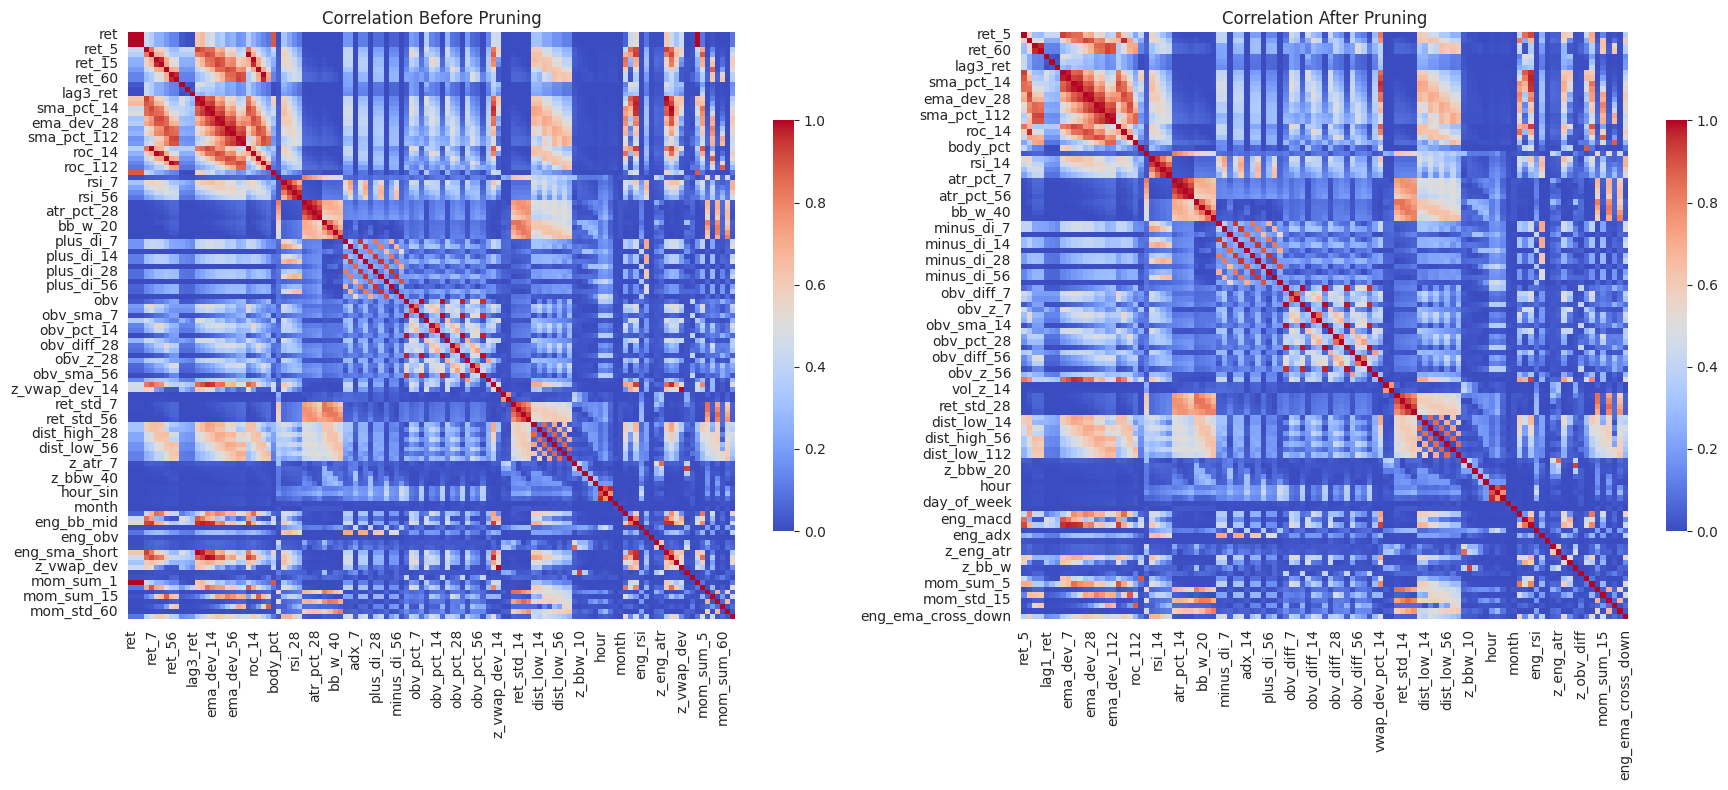

In [4]:
# importlib.reload(params) #########
# importlib.reload(feats) #########
# importlib.reload(plots) #########

kept_final_feats, pruned_feats, corr_full, corr_pruned = feats.prune_features_by_variance_and_correlation(
    X_all=X_all,
    y=y,
    min_std=params.feats_min_std,
    max_corr=params.feats_max_corr,
)

# show heatmaps
plots.plot_correlation_before_after(corr_full, corr_pruned)

In [5]:
# build final feature DataFrame if needed
df_feat_final = df_all_features[kept_final_feats + [params.label_col] + ['close_raw']]

df_feat_final

,ret_5,ret_15,ret_56,ret_60,lag1_ret,lag2_ret,lag3_ret,sma_pct_7,ema_dev_7,sma_pct_14,ema_dev_14,sma_pct_28,ema_dev_28,sma_pct_56,ema_dev_56,sma_pct_112,ema_dev_112,roc_7,roc_14,roc_28,roc_112,body_pct,range_pct,rsi_7,rsi_14,rsi_28,rsi_56,atr_pct_7,atr_pct_14,atr_pct_28,atr_pct_56,bb_w_10,bb_w_20,bb_w_40,bb_w_80,plus_di_7,minus_di_7,adx_7,plus_di_14,minus_di_14,adx_14,plus_di_28,minus_di_28,adx_28,plus_di_56,minus_di_56,adx_56,obv,obv_diff_7,obv_pct_7,obv_sma_7,obv_z_7,obv_diff_14,obv_pct_14,obv_sma_14,obv_z_14,obv_diff_28,obv_pct_28,obv_sma_28,obv_z_28,obv_diff_56,obv_pct_56,obv_sma_56,obv_z_56,vwap_dev_pct_14,vol_spike_14,vol_z_14,ret_std_7,ret_std_14,ret_std_28,ret_std_56,dist_high_14,dist_low_14,dist_high_28,dist_low_28,dist_high_56,dist_low_56,dist_high_112,dist_low_112,z_atr_7,z_bbw_10,z_bbw_20,z_bbw_40,z_bbw_80,hour,hour_sin,hour_cos,day_of_week,month,eng_ma,eng_macd,eng_bb_mid,eng_rsi,eng_adx,eng_obv,eng_atr_div,z_eng_atr,eng_vwap,z_vwap_dev,z_bb_w,z_obv_diff,mom_sum_1,mom_sum_5,mom_std_5,mom_sum_15,mom_std_15,mom_sum_60,mom_std_60,eng_ema_cross_down,signal,close_raw
2004-01-02 11:18:00,0.504401,0.501420,0.492760,0.493031,0.502438,0.502259,0.502199,0.509319,0.513015,0.508883,0.511325,0.505841,0.512418,0.508646,0.515558,0.508615,0.517730,0.504418,0.501489,0.503029,0.486750,0.501855,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.317821,0.516555,1.000000,0.316582,0.536419,0.520217,1.000000,0.314543,0.517635,0.528677,1.000000,0.311009,0.506716,0.547210,1.000000,0.302876,0.505784,0.506791,0.078689,0.437947,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.482422,0.493447,0.468497,0.418909,0.363469,0.0,1.000000,0.01996,1.0,0.000000,0.509201,0.495990,0.486806,1.000000,0.500000,0.492535,0.394681,0.434185,0.497478,0.499637,0.480596,0.733477,0.502501,0.504869,0.000000,0.500494,0.000000,0.500701,0.000000,0.0,0.000008,0.764286
2004-01-02 11:19:00,0.504401,0.501420,0.492760,0.493031,0.502438,0.502259,0.502199,0.509319,0.513015,0.508883,0.511325,0.505841,0.512418,0.508646,0.515558,0.508615,0.517730,0.504418,0.501489,0.503029,0.486750,0.501855,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.319701,0.516555,1.000000,0.318498,0.536419,0.520217,1.000000,0.316501,0.517635,0.528677,1.000000,0.313055,0.506716,0.547210,1.000000,0.305119,0.505784,0.506791,0.078689,0.437947,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.482422,0.493447,0.468497,0.418909,0.363469,0.0,1.000000,0.01996,1.0,0.000000,0.509201,0.495990,0.486806,1.000000,0.500000,0.492532,0.394681,0.434185,0.497478,0.499637,0.480596,0.733324,0.502501,0.504869,0.000000,0.500494,0.000000,0.500701,0.000000,0.0,0.000008,0.764286
2004-01-02 11:20:00,0.504401,0.501420,0.492760,0.493031,0.502438,0.502259,0.502199,0.509319,0.513015,0.508883,0.511325,0.505841,0.512418,0.508646,0.515558,0.508615,0.517730,0.504418,0.501489,0.503029,0.486750,0.501855,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.321581,0.516555,1.000000,0.320414,0.536419,0.520217,1.000000,0.318459,0.517635,0.528677,1.000000,0.315101,0.506716,0.547210,1.000000,0.307362,0.505784,0.506791,0.078689,0.437947,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.482422,0.493447,0.468497,0.418909,0.363469,0.0,1.000000,0.01996,1.0,0.000000,0.509201,0.495990,0.486806,1.000000,0.500000,0.492529,0.394681,0.434185,0.497478,0.499637,0.

In [6]:
train_loader, val_loader, test_loader, end_times_tr, end_times_val, end_times_te = models_core.model_core_pipeline(
    df             = df_feat_final,
    look_back      = params.hparams["LOOK_BACK"],
    sess_start     = params.sess_start_pred_tick,
    train_prop     = params.train_prop,
    val_prop       = params.val_prop,
    train_batch    = params.hparams["TRAIN_BATCH"],
    train_workers  = params.hparams["TRAIN_WORKERS"],
    prefetch_factor= params.hparams["TRAIN_PREFETCH_FACTOR"],
    signal_thresh  = params.best_optuna_params["buy_threshold"],
    return_thresh  = params.return_threshold_tick
)


Preparing days:   0%|          | 0/5400 [00:00<?, ?it/s]

N_total: 2273400 look_back: 30 F: 109
Estimated X_buf size: 29.74 GB — using RAM (in-memory) (thresh 30 GiB)


Writing days:   0%|          | 0/5400 [00:00<?, ?it/s]

Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

In [7]:
# for name, ld, tm in zip(
#     ["train","val","test"],
#     [train_loader, val_loader, test_loader],
#     [end_times_tr, end_times_val, end_times_te]
# ):
#     models_core.summarize_split(name, ld, tm)


In [8]:
# importlib.reload(models_custom) #############

# -----------------------------------------------------------------------------
# Instantiate the ModelClass & move to device
# -----------------------------------------------------------------------------

model = models_custom.ModelClass(
    n_feats             = len(kept_final_feats),
    short_units         = params.hparams["SHORT_UNITS"],
    long_units          = params.hparams["LONG_UNITS"],
    transformer_d_model = params.hparams["TRANSFORMER_D_MODEL"],
    transformer_layers  = params.hparams["TRANSFORMER_LAYERS"],
    dropout_short       = params.hparams["DROPOUT_SHORT"],
    dropout_long        = params.hparams["DROPOUT_LONG"],
    dropout_trans       = params.hparams["DROPOUT_TRANS"],
    pred_hidden         = params.hparams["PRED_HIDDEN"],
    window_len          = params.hparams["LOOK_BACK"],

    # Gating flags
    use_conv            = params.hparams["USE_CONV"],
    use_tcn             = params.hparams["USE_TCN"],
    use_short_lstm      = params.hparams["USE_SHORT_LSTM"],
    use_transformer     = params.hparams["USE_TRANSFORMER"],
    use_long_lstm       = params.hparams["USE_LONG_LSTM"],
    use_delta           = params.hparams["USE_DELTA"],
    flatten_mode        = params.hparams["FLATTEN_MODE"]
)

model.feature_names = kept_final_feats # for logging
model.to(params.device)  
    
model

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:375: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


ModelClass(
  (conv): Identity()
  (bn): Identity()
  (relu): ReLU()
  (tcn): Identity()
  (ln_short): Identity()
  (do_short): Identity()
  (feature_proj): Linear(in_features=109, out_features=128, bias=True)
  (pos_enc): PositionalEncoding(
    (dropout): Dropout(p=0.05, inplace=False)
  )
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=512, bias=True)
        (dropout): Dropout(p=0.05, inplace=False)
        (linear2): Linear(in_features=512, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.05, inplace=False)
        (dropout2): Dropout(p=0.05, inplace=False)
      )
    )

In [9]:
optimizer = AdamW(
  model.parameters(),
  lr           = params.hparams["ONECYCLE_MAX_LR"],
  weight_decay = params.hparams["WEIGHT_DECAY"]
)

batches_per_epoch = len(train_loader)
total_steps = batches_per_epoch * params.hparams["MAX_EPOCHS"]

scheduler = OneCycleLR(
  optimizer,
  max_lr           = params.hparams["ONECYCLE_MAX_LR"],
  total_steps      = total_steps,
  pct_start        = params.hparams["ONECYCLE_PCT_START"],
  div_factor       = params.hparams["ONECYCLE_DIV_FACTOR"],
  final_div_factor = params.hparams["ONECYCLE_FINAL_DIV"],
  anneal_strategy  = params.hparams["ONECYCLE_STRATEGY"],
)
optimizer.scheduler = scheduler # necessary to log sched_field

if getattr(scheduler, "total_steps", None) != total_steps:
    raise RuntimeError(f"Scheduler total_steps mismatch: scheduler={getattr(scheduler,'total_steps',None)} expected={total_steps}")

scheduler

Training sees 3792 unique trading days per epoch.

Model parameters: total=626,307, trainable=626,307

Using HyperParameters:
 {'USE_CONV': False, 'CONV_K': 3, 'CONV_DILATION': 1, 'CONV_CHANNELS': 64, 'USE_TCN': False, 'TCN_LAYERS': 3, 'TCN_KERNEL': 3, 'TCN_CHANNELS': 128, 'USE_SHORT_LSTM': False, 'SHORT_UNITS': 128, 'DROPOUT_SHORT': 0.1, 'USE_TRANSFORMER': True, 'TRANSFORMER_D_MODEL': 128, 'TRANSFORMER_LAYERS': 3, 'TRANSFORMER_HEADS': 4, 'TRANSFORMER_FF_MULT': 4, 'DROPOUT_TRANS': 0.05, 'USE_LONG_LSTM': False, 'DROPOUT_LONG': 0.1, 'LONG_UNITS': 128, 'FLATTEN_MODE': 'pool', 'PRED_HIDDEN': 128, 'ALPHA_SMOOTH': 0.0, 'WARMUP_STEPS': 5, 'USE_HUBER': False, 'HUBER_DELTA': 0.1, 'USE_DELTA': False, 'LAMBDA_DELTA': 0.1, 'MAX_EPOCHS': 90, 'EARLY_STOP_PATIENCE': 9, 'WEIGHT_DECAY': 1e-05, 'CLIPNORM': 5, 'ONECYCLE_MAX_LR': 0.0007, 'ONECYCLE_DIV_FACTOR': 10, 'ONECYCLE_FINAL_DIV': 100, 'ONECYCLE_PCT_START': 0.1, 'ONECYCLE_STRATEGY': 'cos', 'TRAIN_BATCH': 16, 'VAL_BATCH': 1, 'TRAIN_WORKERS': 8, 'TRAIN

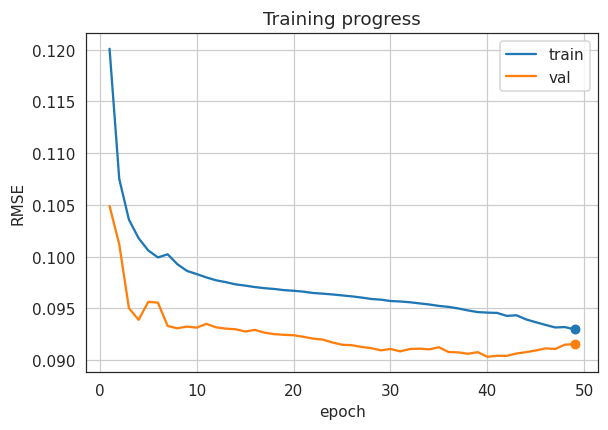

Epoch 1 ▶ Train:   0%|          | 0/237 [00:01<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

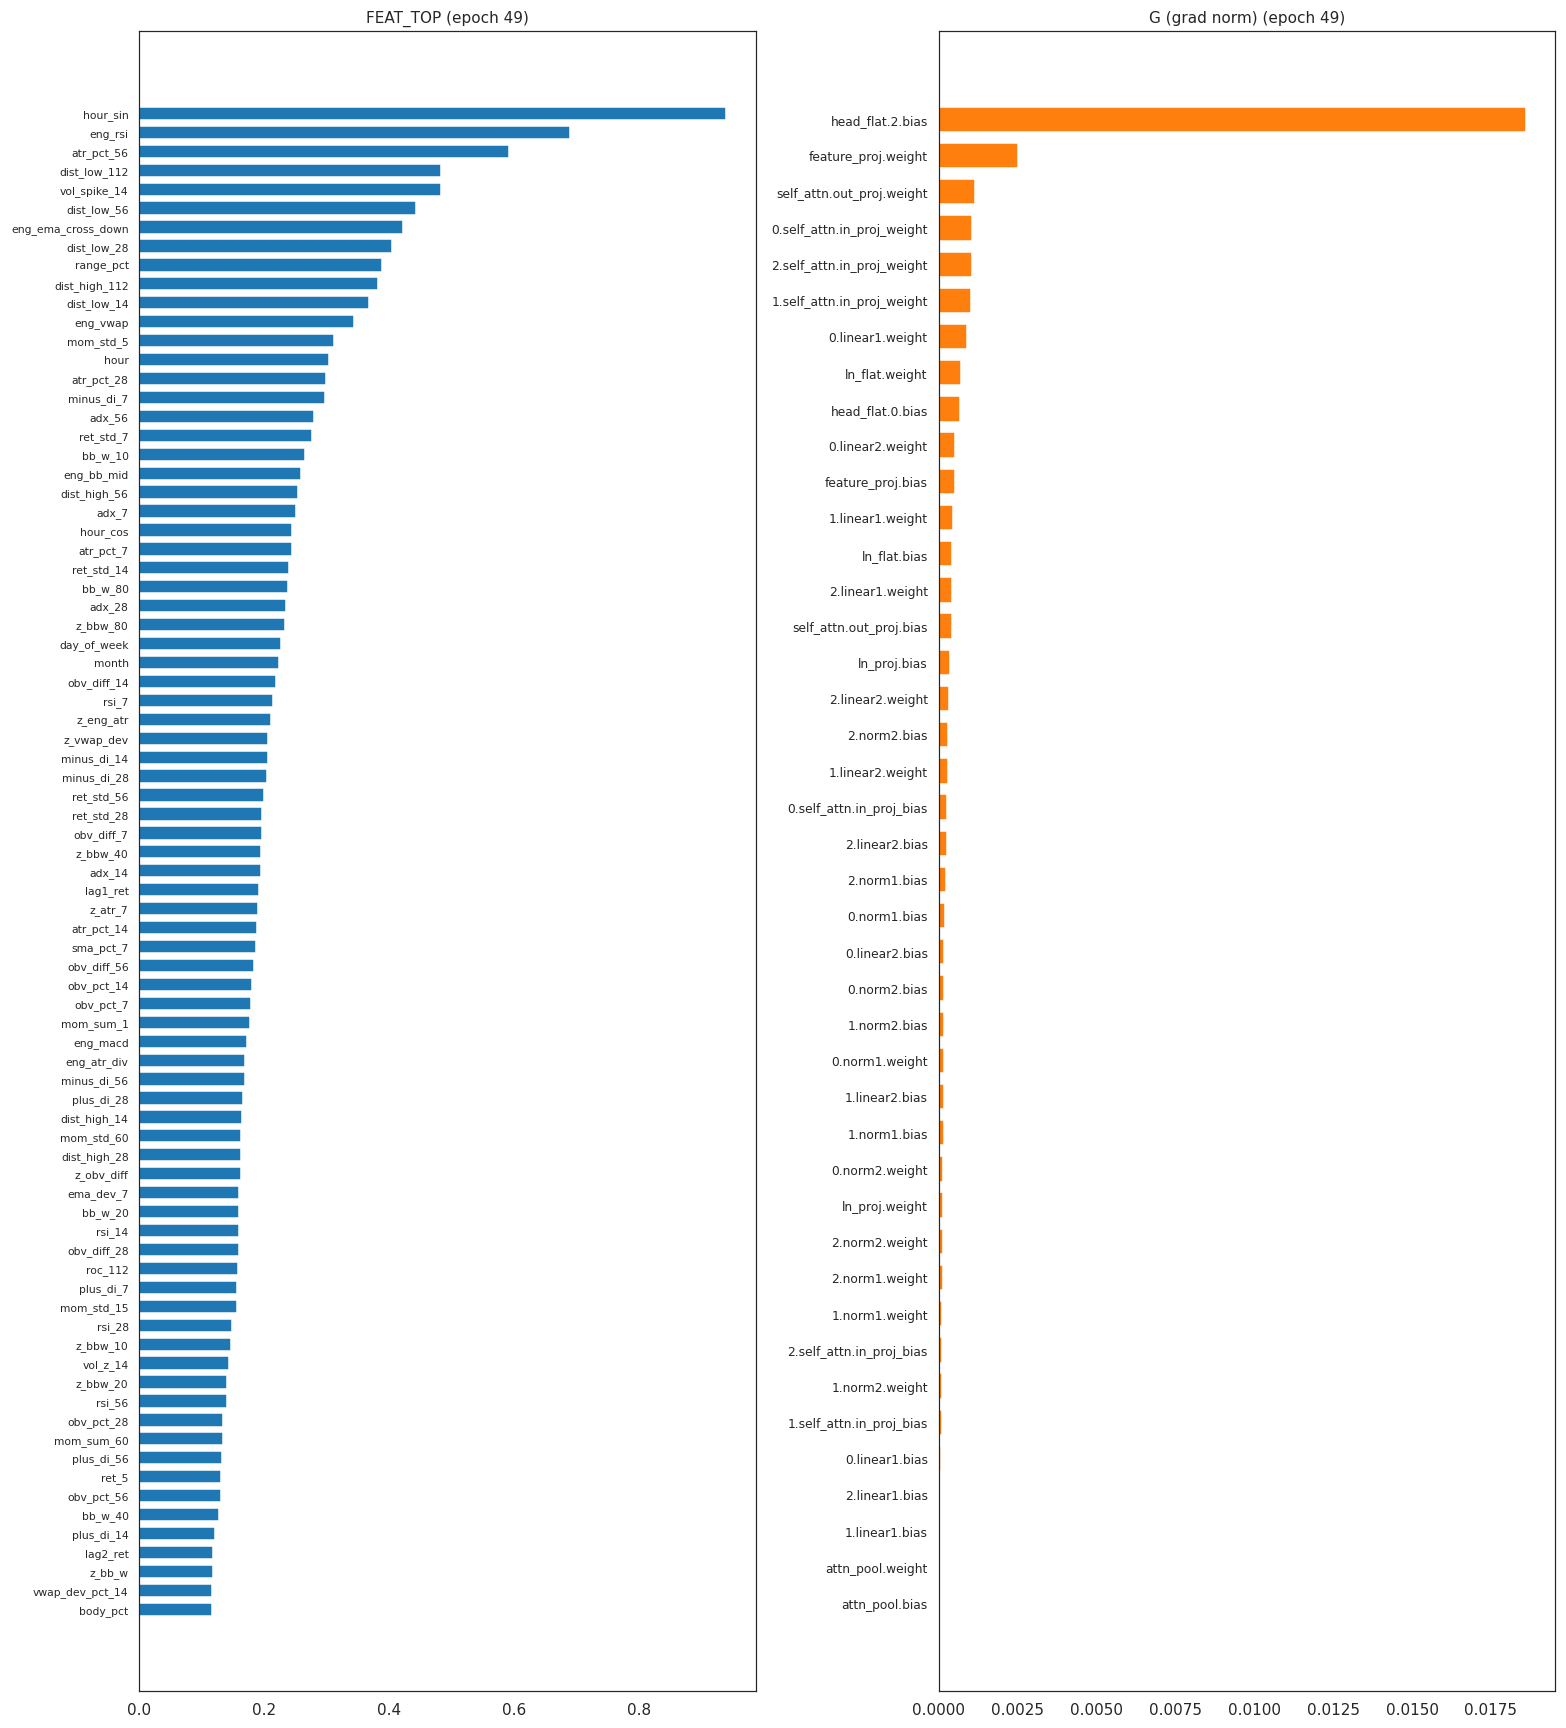

Epoch 01  TRAIN→ RMSE=0.12009, R²=-0.098 |  VALID→ RMSE=0.10489, R²=0.070 |  lr=8.90e-05 |  loss=1.44218e-02 |  improved=True


Epoch 2 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 02  TRAIN→ RMSE=0.10752, R²=0.120 |  VALID→ RMSE=0.10121, R²=0.135 |  lr=1.44e-04 |  loss=1.15606e-02 |  improved=True


Epoch 3 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 03  TRAIN→ RMSE=0.10358, R²=0.183 |  VALID→ RMSE=0.09503, R²=0.237 |  lr=2.28e-04 |  loss=1.07295e-02 |  improved=True


Epoch 4 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 04  TRAIN→ RMSE=0.10179, R²=0.211 |  VALID→ RMSE=0.09391, R²=0.255 |  lr=3.31e-04 |  loss=1.03610e-02 |  improved=True


Epoch 5 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 05  TRAIN→ RMSE=0.10060, R²=0.229 |  VALID→ RMSE=0.09564, R²=0.227 |  lr=4.40e-04 |  loss=1.01209e-02 |  improved=False


Epoch 6 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 06  TRAIN→ RMSE=0.09993, R²=0.240 |  VALID→ RMSE=0.09556, R²=0.229 |  lr=5.43e-04 |  loss=9.98640e-03 |  improved=False


Epoch 7 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 07  TRAIN→ RMSE=0.10024, R²=0.235 |  VALID→ RMSE=0.09331, R²=0.265 |  lr=6.27e-04 |  loss=1.00473e-02 |  improved=True


Epoch 8 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 08  TRAIN→ RMSE=0.09928, R²=0.249 |  VALID→ RMSE=0.09309, R²=0.268 |  lr=6.81e-04 |  loss=9.85596e-03 |  improved=True


Epoch 9 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 09  TRAIN→ RMSE=0.09863, R²=0.259 |  VALID→ RMSE=0.09325, R²=0.265 |  lr=7.00e-04 |  loss=9.72731e-03 |  improved=False


Epoch 10 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 10  TRAIN→ RMSE=0.09832, R²=0.264 |  VALID→ RMSE=0.09315, R²=0.267 |  lr=7.00e-04 |  loss=9.66717e-03 |  improved=False


Epoch 11 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 11  TRAIN→ RMSE=0.09800, R²=0.269 |  VALID→ RMSE=0.09352, R²=0.261 |  lr=6.99e-04 |  loss=9.60379e-03 |  improved=False


Epoch 12 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 12  TRAIN→ RMSE=0.09772, R²=0.273 |  VALID→ RMSE=0.09318, R²=0.267 |  lr=6.98e-04 |  loss=9.54959e-03 |  improved=False


Epoch 13 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 13  TRAIN→ RMSE=0.09754, R²=0.275 |  VALID→ RMSE=0.09305, R²=0.268 |  lr=6.96e-04 |  loss=9.51456e-03 |  improved=True


Epoch 14 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 14  TRAIN→ RMSE=0.09733, R²=0.279 |  VALID→ RMSE=0.09299, R²=0.269 |  lr=6.93e-04 |  loss=9.47323e-03 |  improved=True


Epoch 15 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 15  TRAIN→ RMSE=0.09721, R²=0.280 |  VALID→ RMSE=0.09278, R²=0.273 |  lr=6.91e-04 |  loss=9.44986e-03 |  improved=True


Epoch 16 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 16  TRAIN→ RMSE=0.09707, R²=0.282 |  VALID→ RMSE=0.09293, R²=0.270 |  lr=6.87e-04 |  loss=9.42216e-03 |  improved=False


Epoch 17 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 17  TRAIN→ RMSE=0.09696, R²=0.284 |  VALID→ RMSE=0.09266, R²=0.275 |  lr=6.83e-04 |  loss=9.40124e-03 |  improved=True


Epoch 18 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 18  TRAIN→ RMSE=0.09689, R²=0.285 |  VALID→ RMSE=0.09252, R²=0.277 |  lr=6.79e-04 |  loss=9.38673e-03 |  improved=True


Epoch 19 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 19  TRAIN→ RMSE=0.09677, R²=0.287 |  VALID→ RMSE=0.09245, R²=0.278 |  lr=6.74e-04 |  loss=9.36494e-03 |  improved=True


Epoch 20 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 20  TRAIN→ RMSE=0.09671, R²=0.288 |  VALID→ RMSE=0.09242, R²=0.278 |  lr=6.69e-04 |  loss=9.35301e-03 |  improved=True


Epoch 21 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 21  TRAIN→ RMSE=0.09663, R²=0.289 |  VALID→ RMSE=0.09226, R²=0.281 |  lr=6.63e-04 |  loss=9.33667e-03 |  improved=True


Epoch 22 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 22  TRAIN→ RMSE=0.09650, R²=0.291 |  VALID→ RMSE=0.09209, R²=0.284 |  lr=6.56e-04 |  loss=9.31200e-03 |  improved=True


Epoch 23 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 23  TRAIN→ RMSE=0.09643, R²=0.292 |  VALID→ RMSE=0.09200, R²=0.285 |  lr=6.50e-04 |  loss=9.29916e-03 |  improved=True


Epoch 24 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 24  TRAIN→ RMSE=0.09636, R²=0.293 |  VALID→ RMSE=0.09172, R²=0.289 |  lr=6.42e-04 |  loss=9.28453e-03 |  improved=True


Epoch 25 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 25  TRAIN→ RMSE=0.09626, R²=0.294 |  VALID→ RMSE=0.09149, R²=0.293 |  lr=6.35e-04 |  loss=9.26665e-03 |  improved=True


Epoch 26 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 26  TRAIN→ RMSE=0.09617, R²=0.296 |  VALID→ RMSE=0.09145, R²=0.293 |  lr=6.27e-04 |  loss=9.24867e-03 |  improved=True


Epoch 27 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 27  TRAIN→ RMSE=0.09606, R²=0.297 |  VALID→ RMSE=0.09128, R²=0.296 |  lr=6.18e-04 |  loss=9.22686e-03 |  improved=True


Epoch 28 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 28  TRAIN→ RMSE=0.09592, R²=0.299 |  VALID→ RMSE=0.09117, R²=0.298 |  lr=6.09e-04 |  loss=9.20058e-03 |  improved=True


Epoch 29 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 29  TRAIN→ RMSE=0.09585, R²=0.300 |  VALID→ RMSE=0.09096, R²=0.301 |  lr=6.00e-04 |  loss=9.18751e-03 |  improved=True


Epoch 30 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 30  TRAIN→ RMSE=0.09572, R²=0.302 |  VALID→ RMSE=0.09109, R²=0.299 |  lr=5.90e-04 |  loss=9.16246e-03 |  improved=False


Epoch 31 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 31  TRAIN→ RMSE=0.09568, R²=0.303 |  VALID→ RMSE=0.09086, R²=0.303 |  lr=5.80e-04 |  loss=9.15387e-03 |  improved=True


Epoch 32 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 32  TRAIN→ RMSE=0.09560, R²=0.304 |  VALID→ RMSE=0.09108, R²=0.299 |  lr=5.70e-04 |  loss=9.13970e-03 |  improved=False


Epoch 33 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 33  TRAIN→ RMSE=0.09549, R²=0.306 |  VALID→ RMSE=0.09112, R²=0.299 |  lr=5.59e-04 |  loss=9.11877e-03 |  improved=False


Epoch 34 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 34  TRAIN→ RMSE=0.09538, R²=0.307 |  VALID→ RMSE=0.09105, R²=0.300 |  lr=5.48e-04 |  loss=9.09824e-03 |  improved=False


Epoch 35 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 35  TRAIN→ RMSE=0.09525, R²=0.309 |  VALID→ RMSE=0.09125, R²=0.296 |  lr=5.37e-04 |  loss=9.07211e-03 |  improved=False


Epoch 36 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 36  TRAIN→ RMSE=0.09515, R²=0.310 |  VALID→ RMSE=0.09079, R²=0.304 |  lr=5.25e-04 |  loss=9.05430e-03 |  improved=True


Epoch 37 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 37  TRAIN→ RMSE=0.09500, R²=0.313 |  VALID→ RMSE=0.09076, R²=0.304 |  lr=5.13e-04 |  loss=9.02532e-03 |  improved=True


Epoch 38 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 38  TRAIN→ RMSE=0.09481, R²=0.315 |  VALID→ RMSE=0.09062, R²=0.306 |  lr=5.01e-04 |  loss=8.98909e-03 |  improved=True


Epoch 39 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 39  TRAIN→ RMSE=0.09465, R²=0.318 |  VALID→ RMSE=0.09078, R²=0.304 |  lr=4.89e-04 |  loss=8.95910e-03 |  improved=False


Epoch 40 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 40  TRAIN→ RMSE=0.09460, R²=0.319 |  VALID→ RMSE=0.09033, R²=0.311 |  lr=4.76e-04 |  loss=8.94911e-03 |  improved=True


Epoch 41 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 41  TRAIN→ RMSE=0.09457, R²=0.319 |  VALID→ RMSE=0.09043, R²=0.309 |  lr=4.64e-04 |  loss=8.94377e-03 |  improved=False


Epoch 42 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 42  TRAIN→ RMSE=0.09428, R²=0.323 |  VALID→ RMSE=0.09042, R²=0.309 |  lr=4.51e-04 |  loss=8.88959e-03 |  improved=False


Epoch 43 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 43  TRAIN→ RMSE=0.09434, R²=0.322 |  VALID→ RMSE=0.09065, R²=0.306 |  lr=4.38e-04 |  loss=8.90079e-03 |  improved=False


Epoch 44 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 44  TRAIN→ RMSE=0.09394, R²=0.328 |  VALID→ RMSE=0.09078, R²=0.304 |  lr=4.24e-04 |  loss=8.82537e-03 |  improved=False


Epoch 45 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 45  TRAIN→ RMSE=0.09367, R²=0.332 |  VALID→ RMSE=0.09094, R²=0.301 |  lr=4.11e-04 |  loss=8.77435e-03 |  improved=False


Epoch 46 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 46  TRAIN→ RMSE=0.09341, R²=0.336 |  VALID→ RMSE=0.09114, R²=0.298 |  lr=3.98e-04 |  loss=8.72590e-03 |  improved=False


Epoch 47 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 47  TRAIN→ RMSE=0.09317, R²=0.339 |  VALID→ RMSE=0.09109, R²=0.299 |  lr=3.84e-04 |  loss=8.67996e-03 |  improved=False


Epoch 48 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 48  TRAIN→ RMSE=0.09320, R²=0.338 |  VALID→ RMSE=0.09150, R²=0.293 |  lr=3.71e-04 |  loss=8.68684e-03 |  improved=False


Epoch 49 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 49  TRAIN→ RMSE=0.09298, R²=0.342 |  VALID→ RMSE=0.09155, R²=0.292 |  lr=3.57e-04 |  loss=8.64457e-03 |  improved=False
✅ Final‐best model saved: AAPL_0.09033_fin.pth


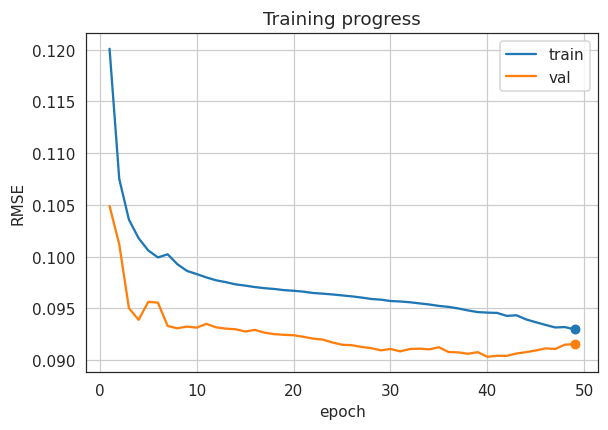

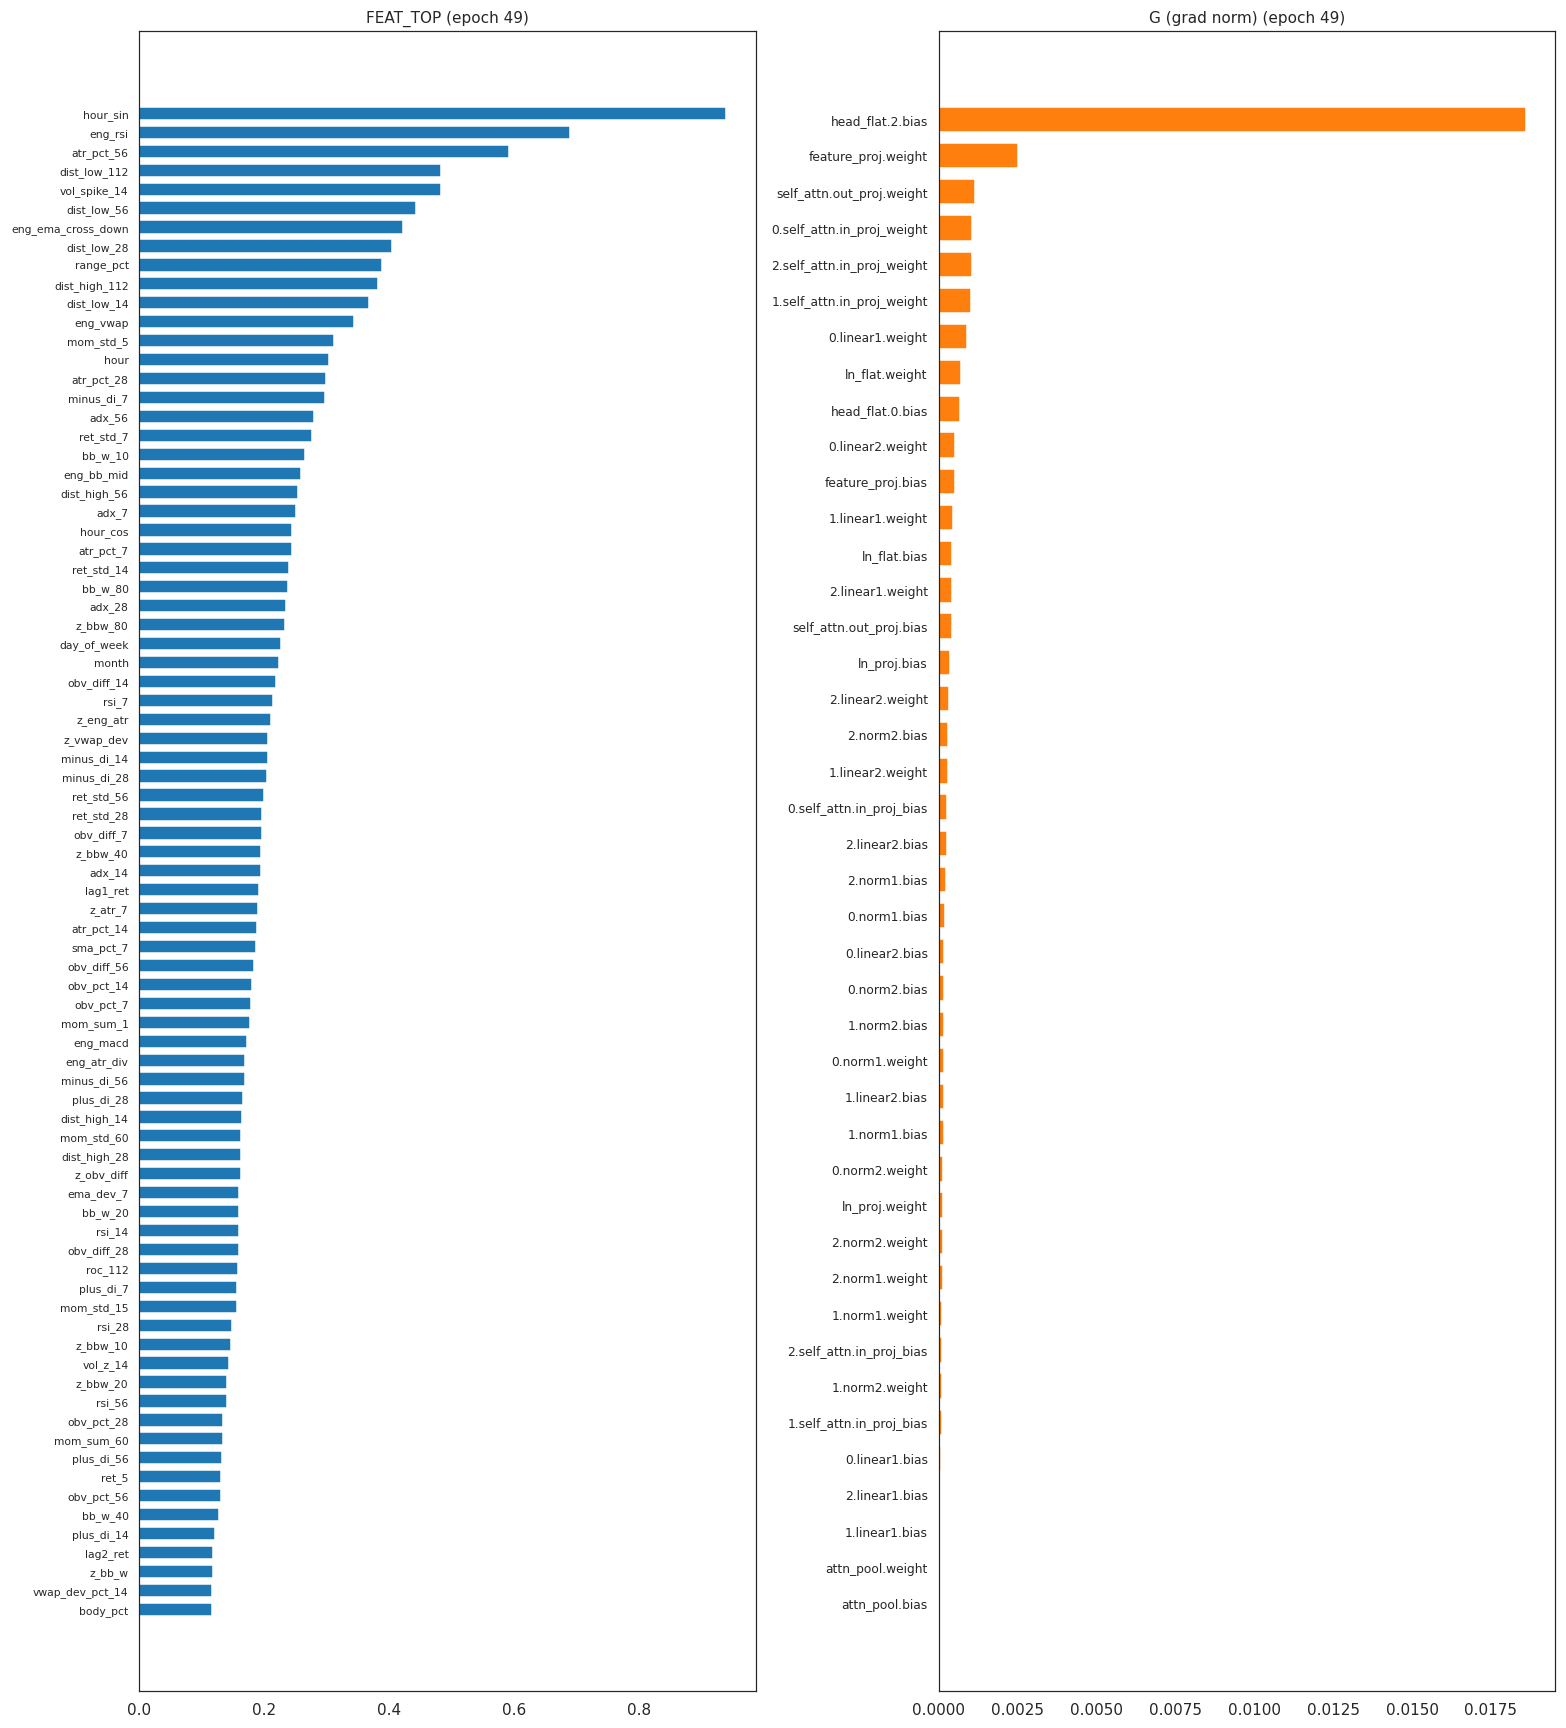

In [10]:

n_days = len(train_loader.dataset)
print(f"Training sees {n_days} unique trading days per epoch.\n")

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model parameters: total={total_params:,}, trainable={trainable_params:,}\n")

print('Using HyperParameters:\n', params.hparams)

# -----------------------------------------------------------------------------
# Run the custom stateful training loop
# -----------------------------------------------------------------------------
best_val_rmse  = models_custom.model_training_loop(
    model               = model,
    optimizer           = optimizer,
    scheduler           = scheduler,
    scaler              = GradScaler(),
    train_loader        = train_loader,
    val_loader          = val_loader,
)


In [11]:
# retrieve model just trained (keep exactly 5 decimals)
fname = f"{params.ticker}_{best_val_rmse:.5f}_fin.pth"
chk = Path(params.models_folder) / fname

# load checkpoint and recreate model from stored hparams
ckpt = torch.load(chk, map_location="cpu", weights_only=False)
h = ckpt["hparams"]

# load weights, move to device, set eval
model.load_state_dict(ckpt["model_state_dict"])
model.eval()

print("Loaded checkpoint:", chk)

Loaded checkpoint: trainings/AAPL_0.09033_fin.pth


In [12]:
# # df_test creation not strictly necessary for the feature importance calculation

# print('Calculating Train metrics and predictions...')
# _, _, train_preds, _, _ = \
#     models_custom.eval_on_loader(train_loader, model)

# print('Calculating Val metrics and predictions...')
# _, _, val_preds, _, _  = \
#     models_custom.eval_on_loader(val_loader,   model)

# print('Calculating Test metrics and predictions...')
# _, _, test_preds, _, _ = \
#     models_custom.eval_on_loader(test_loader,  model)

# print('Adding the predictions to df_test...')
# _, df_test = models_custom.add_preds_and_split(
#     df            = df_feat_final,
#     train_preds   = train_preds,
#     val_preds     = val_preds,
#     test_preds    = test_preds,
#     end_times_tr  = end_times_tr,
#     end_times_val = end_times_val,
#     end_times_te  = end_times_te
# )

# df_test

In [13]:
def extract_windows_from_loader(loader):
    """
    Extract all windows and targets from a DataLoader into numpy arrays.

    Parameters
    - loader: iterable DataLoader that yields batches where
        batch[0] is a tensor with shape (B, L, F) and
        batch[1] is a tensor with shape (B,) (targets).

    Returns
    - X_windows: numpy array, shape (N, L, F)
    - y_windows: numpy array, shape (N,)
    """
    X_chunks, y_chunks = [], []
    for batch in tqdm(loader, desc="Extracting windows"):
        # move tensors to CPU and convert to numpy
        X_chunks.append(batch[0].detach().cpu().numpy())      # (B, L, F)
        y_chunks.append(batch[1].detach().cpu().numpy().reshape(-1))  # (B,)
    X_windows = np.concatenate(X_chunks, axis=0)
    y_windows = np.concatenate(y_chunks, axis=0)
    return X_windows, y_windows


# Extract windows and targets from the test_loader
X_windows, y_windows = extract_windows_from_loader(test_loader)
X_windows.shape, y_windows.shape

Extracting windows: 100%|██████████| 809/809 [00:29<00:00, 27.56it/s]


((340589, 30, 109), (340589,))

In [14]:
# Prepare master dict for feature importances
features_importances = {feat: {} for feat in kept_final_feats}

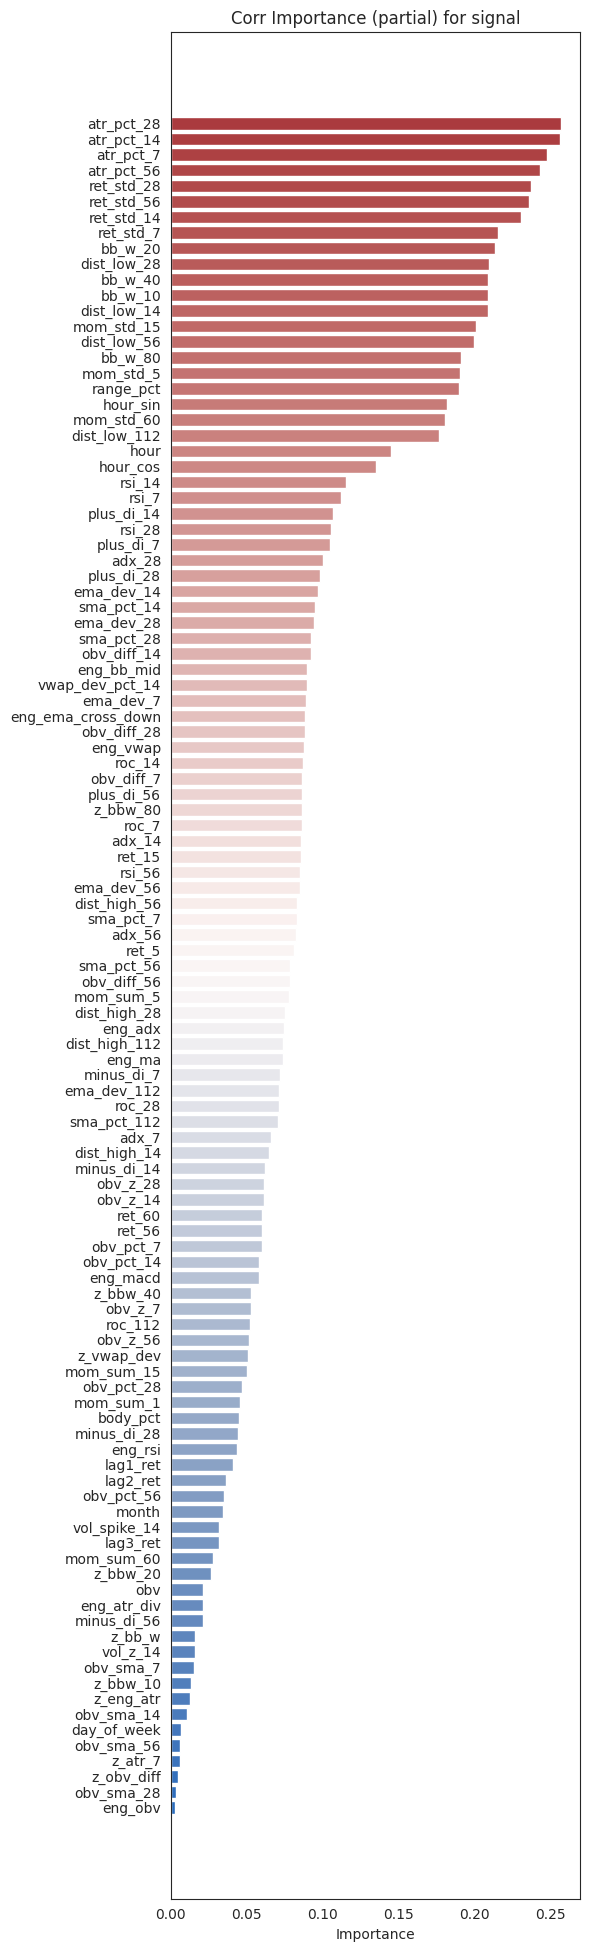

In [15]:
def corr_importance(X_windows, y_windows, feature_names,
                                n_repeats=1, batch_size=1024, seed=0, device=params.device):
    """
    Compute model-level Pearson correlation importance for a trained transformer.

    Returns:
    - pd.Series: absolute Pearson correlation per feature (higher = more important)
    - base_mse: None (no baseline MSE for this univariate data method)
    """
    
    # flatten features across samples and timesteps: shape (N*L, F)
    N, L, F = X_windows.shape
    assert F == len(feature_names), "feature_names length must match X_windows feature axis"
    X_flat = X_windows.reshape(N * L, F)
    y_rep = np.repeat(y_windows, L)

    # compute absolute Pearson per feature (handle constant cols)
    scores = {}
    for fi, fname in enumerate(feature_names):
        col = X_flat[:, fi]
        if np.all(col == col[0]):
            corr_val = 0.0
        else:
            corr_val = np.corrcoef(col, y_rep)[0, 1]
            if np.isnan(corr_val):
                corr_val = 0.0
        scores[fname] = float(abs(corr_val))

    # build final series (sorted desc) and display using shared helper
    imp_series = pd.Series(scores).sort_values(ascending=False)

    # use your common live display helper to reveal results consistently
    # reveal in original feature order (pass feature_names) or ranked order (imp_series.index.tolist())
    _ = feats.live_display_importances(imp_series, features=feature_names, label=params.label_col, method="Corr", batch=4, pause=0.02)

    return imp_series, None


##########################################################################################################################################

imp_corr, _ = corr_importance(X_windows, y_windows, kept_final_feats,
                                         n_repeats=1, batch_size=1024, seed=0, device=params.device)

feats.update_feature_importances(features_importances, importance_type="corr", values=imp_corr)


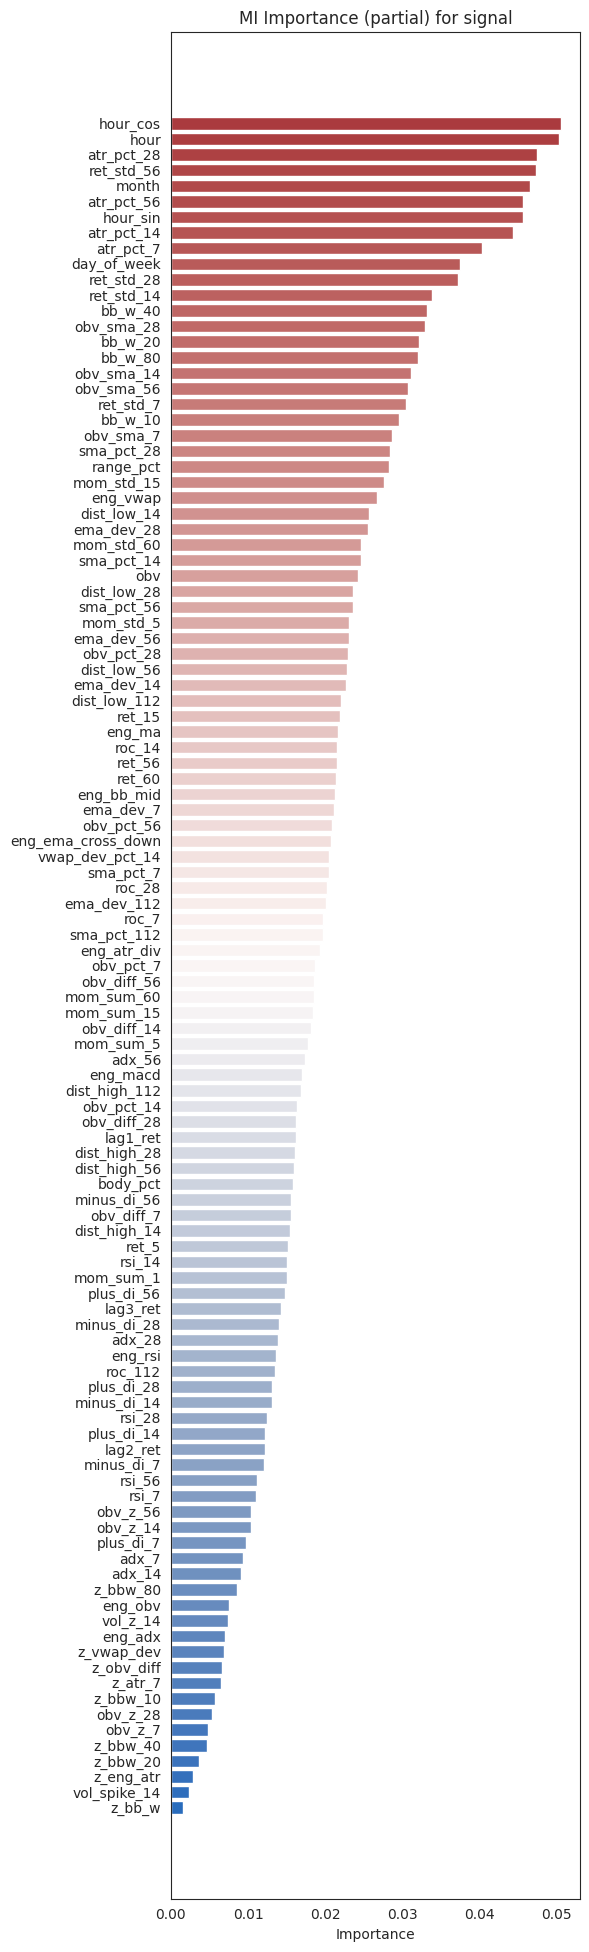

In [16]:

def mi_importance(X_windows, y_windows, feature_names,
                              n_repeats=1, batch_size=1024, seed=0, device=params.device,
                              sample_size=50000, batch_feat_size=32, mi_n_neighbors=5, n_jobs=-1):
    """
    Faster but slightly more precise mutual information importance.

    Same signature as before plus optional tuning params:
    - sample_size: max rows (N*L) to sample for MI estimation (int or None for full)
    - batch_feat_size: number of features per vectorized MI call
    - mi_n_neighbors: number of neighbors passed to mutual_info_regression
    - n_jobs: parallel jobs for mutual_info_regression (-1 uses all cores if supported)

    Returns: (pd.Series sorted desc, None) and updates features_importances like other functions.
    """

    rng = np.random.RandomState(seed)
    N, L, F = X_windows.shape
    assert F == len(feature_names)

    X_flat = X_windows.reshape(N * L, F)
    y_flat = np.repeat(y_windows, L)

    total_rows = X_flat.shape[0]
    scores_acc = np.zeros(F, dtype=float)
    runs = 2  # average two subsample runs (seed, seed+1)

    for run in range(runs):
        run_seed = seed + run
        if sample_size is not None and total_rows > sample_size:
            idx = rng.choice(total_rows, size=sample_size, replace=False)
            X_sub = X_flat[idx, :]
            y_sub = y_flat[idx]
        else:
            X_sub = X_flat
            y_sub = y_flat

        const_mask = np.all(X_sub == X_sub[:1, :], axis=0)

        for start in range(0, F, batch_feat_size):
            cols = list(range(start, min(F, start + batch_feat_size)))
            nonconst = [c for c in cols if not const_mask[c]]
            if nonconst:
                try:
                    mi_vals = mutual_info_regression(X_sub[:, nonconst], y_sub,
                                                     random_state=run_seed,
                                                     n_neighbors=mi_n_neighbors,
                                                     n_jobs=n_jobs)
                except TypeError:
                    mi_vals = mutual_info_regression(X_sub[:, nonconst], y_sub, random_state=run_seed)
                j = 0
                for c in cols:
                    if const_mask[c]:
                        scores_acc[c] += 0.0
                    else:
                        scores_acc[c] += float(mi_vals[j]); j += 1
            else:
                for c in cols:
                    scores_acc[c] += 0.0

        # light pause to let UI breathe between subsample runs
        time.sleep(0.01)

        # partial display using the shared helper (reveals current averaged values)
        partial_series = pd.Series(scores_acc / (run + 1), index=feature_names).sort_values(ascending=False)
        # reveal in original feature order; batch controls update granularity
        _ = feats.live_display_importances(partial_series, features=feature_names, label=params.label_col, method=f"MI (run {run+1}/{runs})", batch=16, pause=0.01)

    mi_avg = scores_acc / runs
    imp_series = pd.Series({feature_names[i]: float(mi_avg[i]) for i in range(F)}).sort_values(ascending=False)
    # final reveal (ranked)
    _ = feats.live_display_importances(imp_series, features=imp_series.index.tolist(), label=params.label_col, method="MI", batch=8, pause=0.02)

    return imp_series, None


##########################################################################################################################################

imp_mi, _ = mi_importance(X_windows, y_windows, kept_final_feats,
                                      n_repeats=1, batch_size=1024, seed=0, device=params.device)

feats.update_feature_importances(features_importances, importance_type="mi", values=imp_mi)


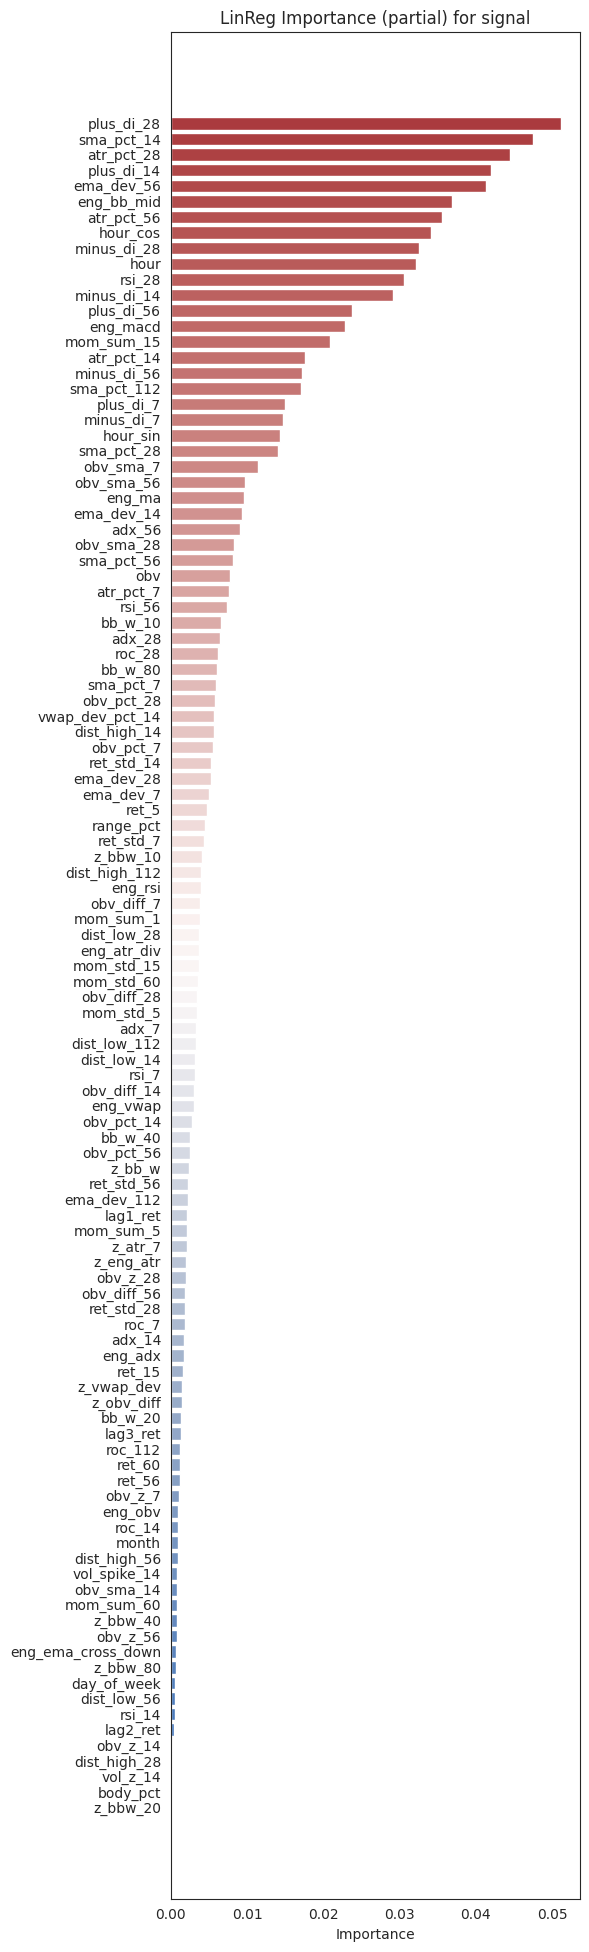

In [17]:

def linreg_coef_importance(X_windows, y_windows, feature_names,
                                       n_repeats=1, batch_size=1024, seed=0, device=params.device):
    """
    Importance from absolute standardized coefficients of a Ridge linear model
    trained on flattened (sample x time) features.

    - Fits a Ridge regression on X_flat (shape N*L, F) -> y_rep (N*L,)
    - Standardizes features before fitting (zero mean, unit std)
    - Uses absolute value of coefficients as importance
    Returns (pd.Series sorted desc, None) and does not change the torch model.
    """

    # prepare flattened data
    N, L, F = X_windows.shape
    assert F == len(feature_names), "feature_names length must match X_windows feature axis"
    X_flat = X_windows.reshape(N * L, F)
    y_flat = np.repeat(y_windows, L)

    # quick initial placeholder so UI shows immediate feedback
    clear_output(wait=True)
    display_text = pd.Series({"status": "Starting linreg importance..."})
    # use live_display_importances to show placeholder (it expects a Series indexed by features)
    placeholder = pd.Series(np.zeros(len(feature_names)), index=feature_names)
    _ = feats.live_display_importances(placeholder, features=feature_names, label=params.label_col, method="LinReg (starting)", batch= max(1, F//10), pause=0.01)

    # standardize features only on a small subsample to avoid allocating full X_std
    scaler = StandardScaler()
    rng = np.random.RandomState(seed)
    subsample_size = min(20000, X_flat.shape[0])
    if X_flat.shape[0] > subsample_size:
        subs_idx = rng.choice(X_flat.shape[0], size=subsample_size, replace=False)
        X_sub_raw = X_flat[subs_idx]
        scaler.fit(X_sub_raw)
        X_sub = scaler.transform(X_sub_raw)
        y_sub = y_flat[subs_idx]
    else:
        X_sub = scaler.fit_transform(X_flat)
        y_sub = y_flat
    
    # free the full flattened array early
    del X_flat
    gc.collect()

    alphas = np.logspace(-3, 3, 13)
    # use RidgeCV but run on subsample
    ridge_cv = RidgeCV(alphas=alphas, scoring="neg_mean_squared_error")
    ridge_cv.fit(X_sub, y_sub)
    best_alpha = float(ridge_cv.alpha_)

    # intermediate reveal after alpha selection (show small text via live_display_importances)
    mid_placeholder = pd.Series(np.zeros(len(feature_names)), index=feature_names)
    # annotate best alpha by temporarily setting the first feature to a nonzero small value so UI shows progress textually
    mid_placeholder.iloc[0] = 0.001
    _ = feats.live_display_importances(mid_placeholder, features=feature_names, label=f"{params.label_col} (alpha={best_alpha:.3g})", method="LinReg (alpha selected)", batch=max(1, F//10), pause=0.01)
    time.sleep(0.01)
    
    # fit final Ridge on standardized data with chosen alpha (fast)
    ridge = Ridge(alpha=best_alpha, solver="auto")
    ridge.fit(X_sub, y_sub)
    coefs = ridge.coef_.flatten() if hasattr(ridge, "coef_") else np.asarray([0.0] * F)
    coefs = np.asarray(coefs).reshape(-1)[:F]

    # importance = absolute standardized coefficient
    scores = {feature_names[i]: float(abs(coefs[i])) for i in range(F)}
    imp_series = pd.Series(scores).sort_values(ascending=False)

    # final reveal using live_display_importances (ranked)
    _ = feats.live_display_importances(imp_series, features=imp_series.index.tolist(), label=params.label_col, method="LinReg", batch=max(1, len(imp_series)//10), pause=0.02)

    return imp_series, None


##############################################################################################################################################


imp_linreg, _ = linreg_coef_importance(
    X_windows, y_windows, kept_final_feats,
    batch_size=1024, seed=0, device=params.device
)

feats.update_feature_importances(features_importances, importance_type="linreg", values=imp_linreg)


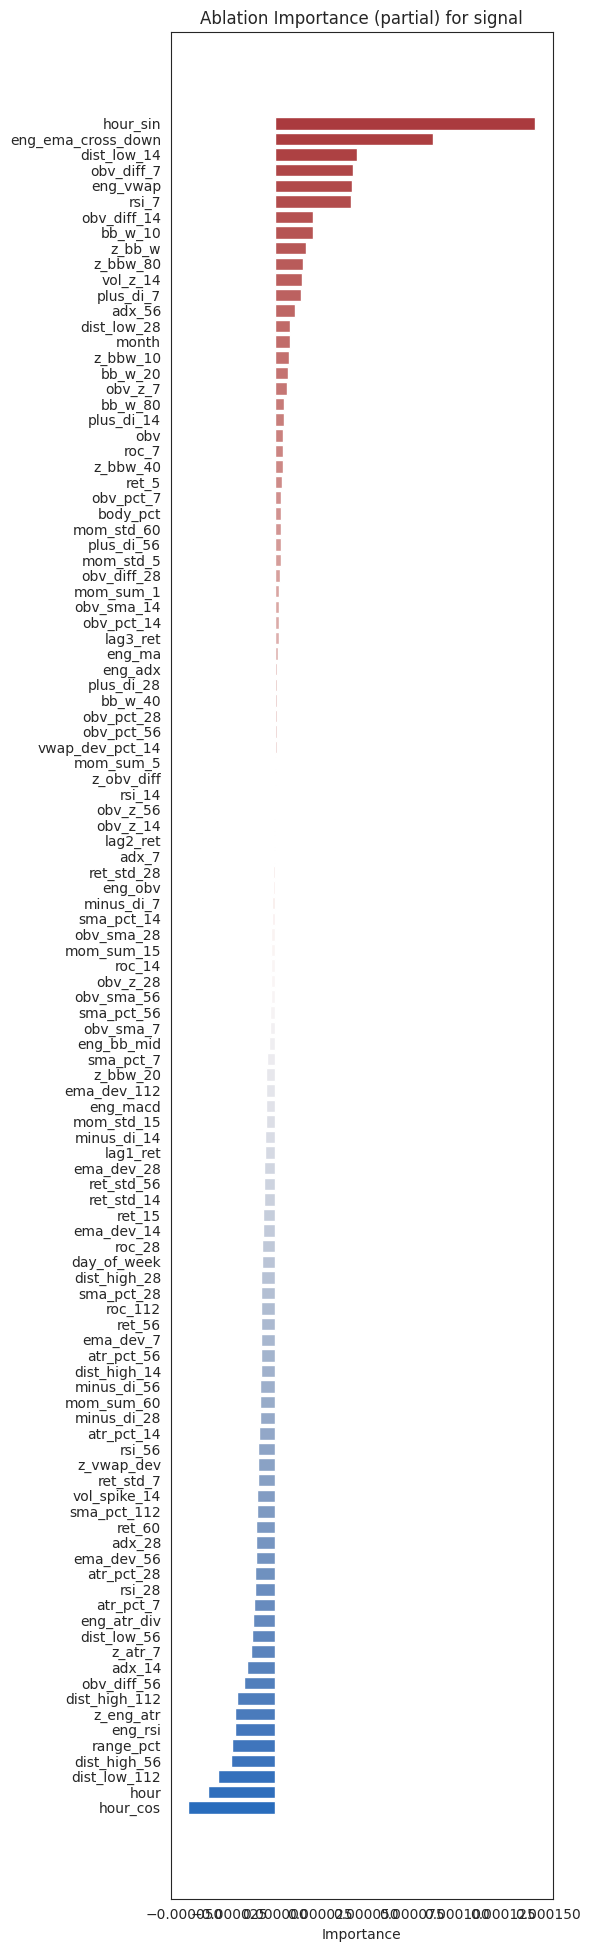

Baseline MSE: 0.007766704


In [18]:

def ablation_importance(model, X_windows, y_windows, feature_names,
                                    n_repeats=1, batch_size=1024, seed=0, device=params.device):
    """
    Importance by ablating (replacing) each feature with its global mean and measuring ΔMSE.
    Returns (pd.Series sorted desc, base_mse) and updates features_importances with importance_type="ablation".
    """

    # baseline using shared helper
    base_pred = feats.predict_windows(model, X_windows, batch_size=batch_size, device=device)
    base_mse = mean_squared_error(y_windows, base_pred)

    N, L, F = X_windows.shape
    assert F == len(feature_names)

    # compute global mean per feature (flatten over samples and timesteps)
    feat_means = X_windows.reshape(N * L, F).mean(axis=0)

    scores = {}
    for fi, fname in enumerate(feature_names):
        orig_col = X_windows[:, :, fi].copy()          # small (N, L) copy
        X_windows[:, :, fi] = feat_means[fi]           # in-place ablation
        pred = feats.predict_windows(model, X_windows, batch_size=batch_size, device=device)
        scores[fname] = float(mean_squared_error(y_windows, pred) - base_mse)
        X_windows[:, :, fi] = orig_col                 # restore
        del orig_col
        gc.collect()

        # periodic partial reveal using shared helper every few features
        if (fi + 1) % 5 == 0 or fi == F - 1:
            partial_series = pd.Series(scores).sort_values(ascending=False)
            # reveal in original feature order for consistency with other methods
            _ = feats.live_display_importances(partial_series, features=feature_names, label=params.label_col, method="Ablation", batch=8, pause=0.02)
            time.sleep(0.01)

    imp_series = pd.Series(scores).sort_values(ascending=False)

    # final reveal (ranked)
    _ = feats.live_display_importances(imp_series, features=imp_series.index.tolist(), label=params.label_col, method="Ablation", batch=8, pause=0.02)

    return imp_series, base_mse


##########################################################################################################################################


imp_abl, baseline_mse = ablation_importance(
    model, X_windows, y_windows, kept_final_feats,
    batch_size=1024, seed=0, device=params.device
)

print("Baseline MSE:", baseline_mse)
feats.update_feature_importances(features_importances, importance_type="ablation", values=imp_abl)


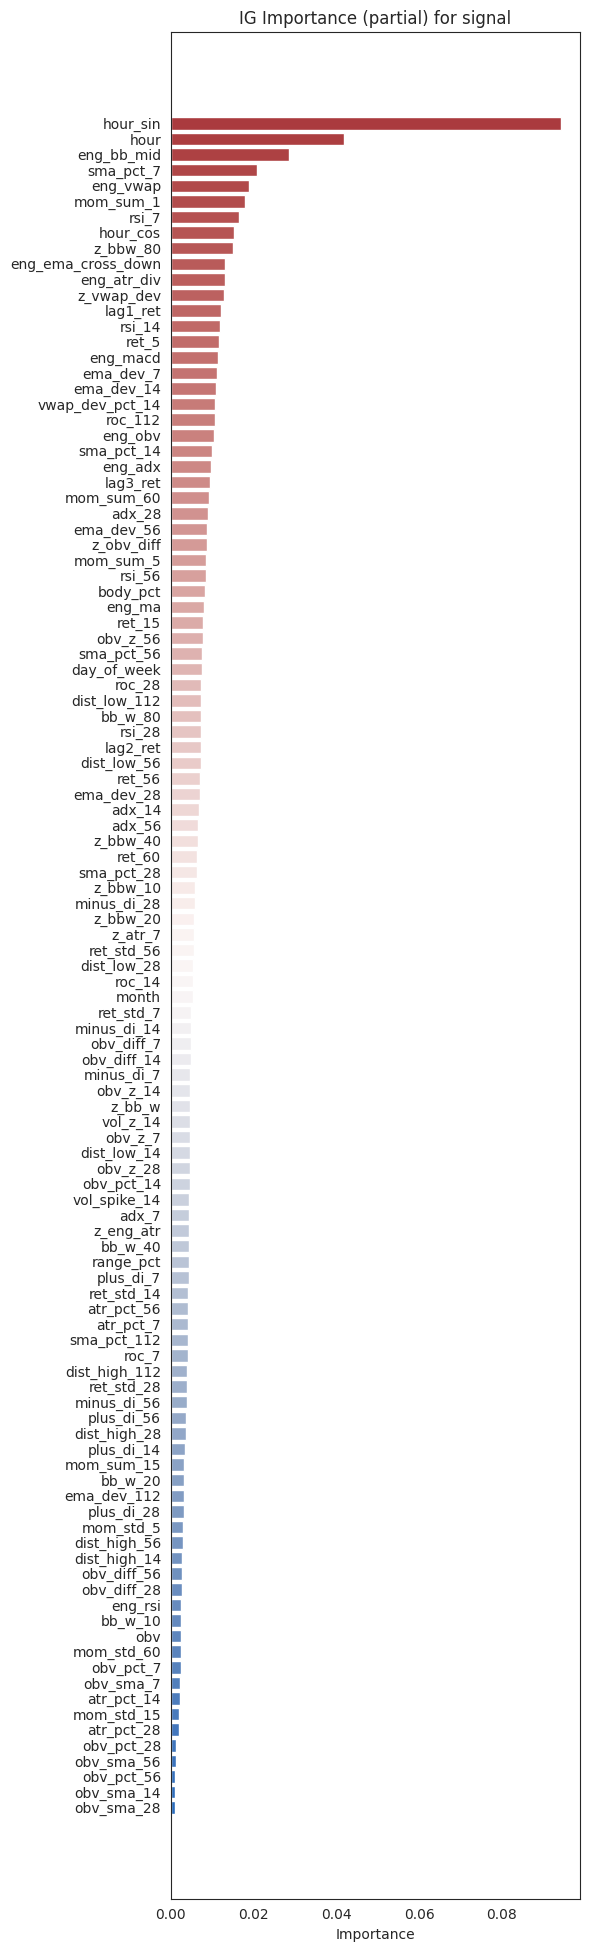

In [19]:
def integrated_gradients_importance(model, X_windows, y_windows, feature_names,
                                    n_steps=50, n_samples=1000, baseline="zero",
                                    batch_size=256, seed=0, device=params.device):
    """
    Integrated Gradients aggregated to per-feature importance (compact, efficient).

    - Computes per-sample IG attributions using batched torch computations and fewer allocations.
    - Aggregates mean(|IG|) over samples and timesteps to give per-feature scores.
    - baseline: "zero", "mean", or a numpy array of shape (L, F).
    - Updates features_importances with importance_type="ig" and returns (pd.Series, None).
    """

    rng = np.random.RandomState(seed)

    model.to(device)
    model.eval()

    N, L, F = X_windows.shape
    assert F == len(feature_names)

    n_explain = min(n_samples, N)
    idx_explain = rng.choice(N, size=n_explain, replace=False) if N > n_explain else np.arange(N)
    X_explain = X_windows[idx_explain].astype("float32")  # (n_explain, L, F)

    # baseline tensor (L, F)
    if isinstance(baseline, str) and baseline == "zero":
        baseline_w = np.zeros((L, F), dtype=np.float32)
    elif isinstance(baseline, str) and baseline == "mean":
        baseline_w = X_windows.mean(axis=0).astype(np.float32)
    elif isinstance(baseline, np.ndarray):
        baseline_w = baseline.astype(np.float32)
        assert baseline_w.shape == (L, F)
    else:
        baseline_w = np.zeros((L, F), dtype=np.float32)

    baseline_t = torch.from_numpy(baseline_w).to(device)

    def batch_attributions(xb_np):
        # xb_np: (B, L, F) float32 numpy
        B = xb_np.shape[0]
        xb_t = torch.from_numpy(xb_np).to(device)                       # (B, L, F)
        grads_acc = torch.zeros_like(xb_t, device=device)               # accumulate grads on device

        # loop over steps but keep tensors on device to reduce allocations
        for step in range(1, n_steps + 1):
            alpha = step / float(n_steps)
            inp = baseline_t.unsqueeze(0) + alpha * (xb_t - baseline_t.unsqueeze(0))  # (B, L, F)
            inp.requires_grad_(True)
            out = model(inp)
            preds = out[0] if isinstance(out, (tuple, list)) else out
            preds = preds.reshape(preds.shape[0], -1).sum(dim=1)  # per-sample scalar
            preds_sum = preds.sum()                              # scalar
            preds_sum.backward()
            grads_acc += inp.grad.detach()
            inp.grad.zero_()
            del inp, out, preds, preds_sum
        # IG estimate: (input - baseline) * avg_grad
        ig_t = (xb_t - baseline_t.unsqueeze(0)) * (grads_acc / float(n_steps))
        return ig_t.cpu().numpy()  # (B, L, F)

    # compute attributions in batches and show partial updates (memory-safe: no growing list)
    running_sum_feats = np.zeros((F,), dtype=np.float64)  # accumulate sum over samples+timesteps for each feature
    processed = 0
    
    for start in range(0, len(X_explain), batch_size):
        xb = X_explain[start:start + batch_size]
        at_batch = batch_attributions(xb)                     # (B, L, F) numpy float32
        # sum absolute attributions over timesteps and samples for this batch -> (F,)
        batch_sum = np.abs(at_batch).sum(axis=(0, 1)).astype(np.float64)
        running_sum_feats += batch_sum
        processed += at_batch.shape[0]
    
        # partial display: mean over processed samples of sum over timesteps -> (F,)
        per_feature_abs = (running_sum_feats / float(processed))
        partial_scores = pd.Series({feature_names[i]: float(per_feature_abs[i]) for i in range(F)}).sort_values(ascending=False)
        _ = feats.live_display_importances(partial_scores, features=feature_names, label=params.label_col, method="IG (partial)", batch=max(1, F//10), pause=0.01)
    
    # final aggregation: mean over all explained samples of sum over timesteps
    per_feature = running_sum_feats / float(processed)  # (F,)

    scores = {feature_names[i]: float(per_feature[i]) for i in range(F)}
    imp_series = pd.Series(scores).sort_values(ascending=False)

    _ = feats.live_display_importances(imp_series, features=imp_series.index.tolist(), label=params.label_col, method="IG", batch=max(1, len(imp_series)//10), pause=0.02)

    feats.update_feature_importances(features_importances, importance_type="ig", values=imp_series)
    return imp_series, None


##########################################################################################################################################

imp_ig, _ = integrated_gradients_importance(
    model, X_windows, y_windows, kept_final_feats,
    n_steps=50, n_samples=1000, baseline="zero",
    batch_size=256, seed=0, device=params.device
)

feats.update_feature_importances(features_importances, importance_type="ig", values=imp_ig)


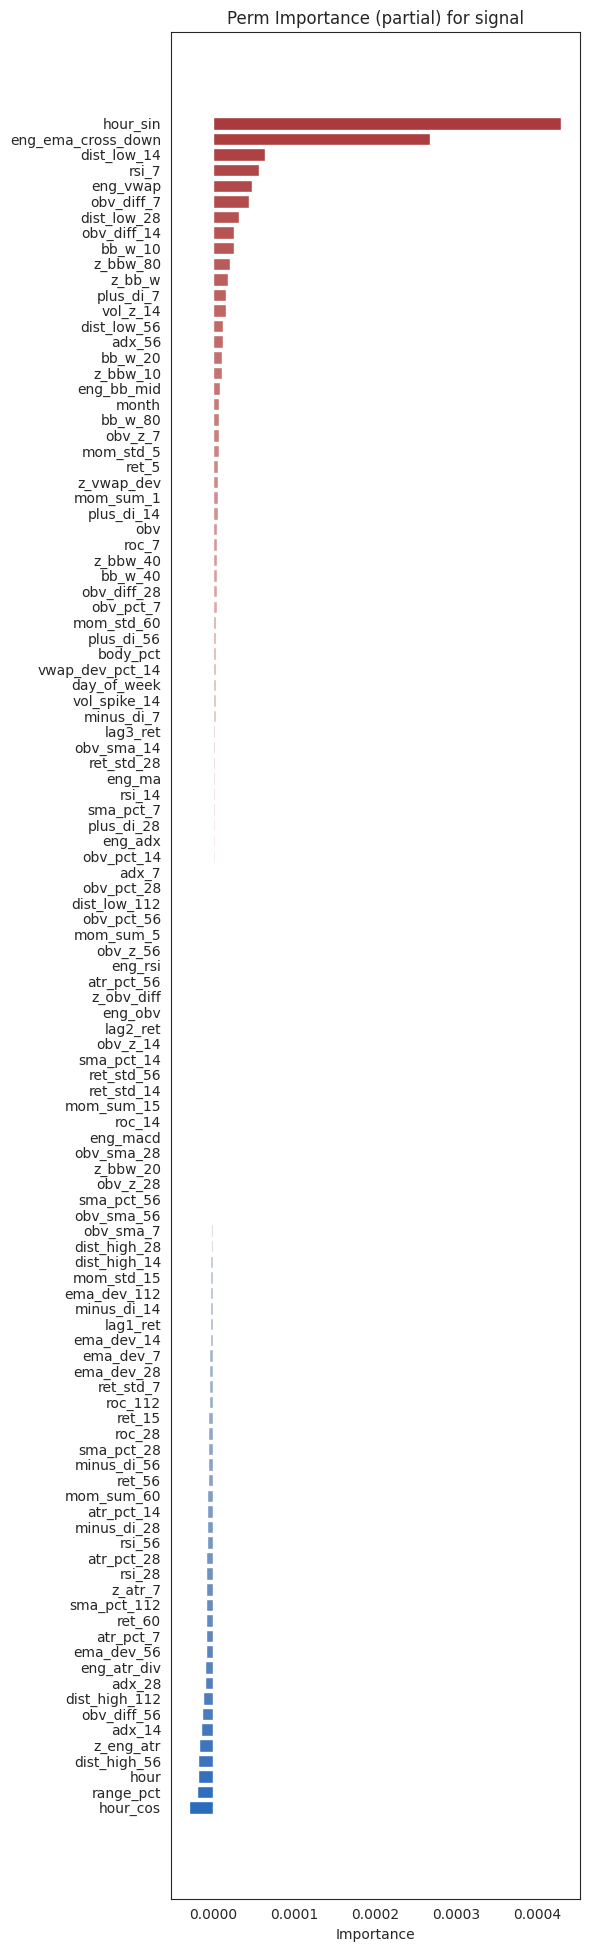

Baseline MSE: 0.007766704


In [21]:

def perm_importance(model, X_windows, y_windows, feature_names,
                                n_repeats=3, batch_size=1024, seed=0, device=params.device):
    """
    Compute model-level permutation importance for a trained transformer.

    Parameters
    - model: trained torch model (in eval mode and moved to device)
    - X_windows: numpy array shape (N, L, F)
    - y_windows: numpy array shape (N,)
    - feature_names: list of length F with feature names (order matches axis 2)
    - n_repeats: number of shuffles per feature
    - batch_size: inference batch size for predict_windows
    - seed: RNG seed for reproducibility
    - device: torch device string or torch.device

    Returns
    - pd.Series: mean ΔMSE per feature (higher = more important)
    - base_mse: baseline mean squared error on original X_windows
    """

    rng = np.random.RandomState(seed)

    # baseline using shared helper
    base_pred = feats.predict_windows(model, X_windows, batch_size=batch_size, device=device)
    base_mse = mean_squared_error(y_windows, base_pred)

    F = X_windows.shape[2]
    assert F == len(feature_names), "feature_names length must match X_windows feature axis"

    scores = {}
    for fi, fname in enumerate(feature_names):
        deltas = []
        for _ in range(n_repeats):
            orig_col = X_windows[:, :, fi].copy()              # small (N, L) copy
            X_windows[:, :, fi] = rng.permutation(orig_col)    # in-place shuffle of the feature slice
            with torch.no_grad():
                pred = feats.predict_windows(model, X_windows, batch_size=batch_size, device=device)
            deltas.append(mean_squared_error(y_windows, pred) - base_mse)
            X_windows[:, :, fi] = orig_col                     # restore original values
            del orig_col
            scores[fname] = float(np.mean(deltas))

        # optional light partial reveal using shared helper
        if (fi + 1) % 5 == 0 or fi == F - 1:
            partial_series = pd.Series(scores).sort_values(ascending=False)
            # reveal in original feature order so UX matches other methods
            _ = feats.live_display_importances(partial_series, features=feature_names, label=params.label_col, method="Perm", batch=8, pause=0.02)
            time.sleep(0.01)

    # prepare final series and show final ranked reveal
    imp_series = pd.Series(scores).sort_values(ascending=False)
    _ = feats.live_display_importances(imp_series, features=imp_series.index.tolist(), label=params.label_col, method="Perm", batch=8, pause=0.02)

    return imp_series, base_mse


##########################################################################################################################################


imp_perm, baseline_mse = perm_importance(
    model, X_windows, y_windows, kept_final_feats,
    n_repeats=3, batch_size=1024, seed=0, device=params.device
)
print("Baseline MSE:", baseline_mse)
feats.update_feature_importances(features_importances, importance_type="perm", values=imp_perm)



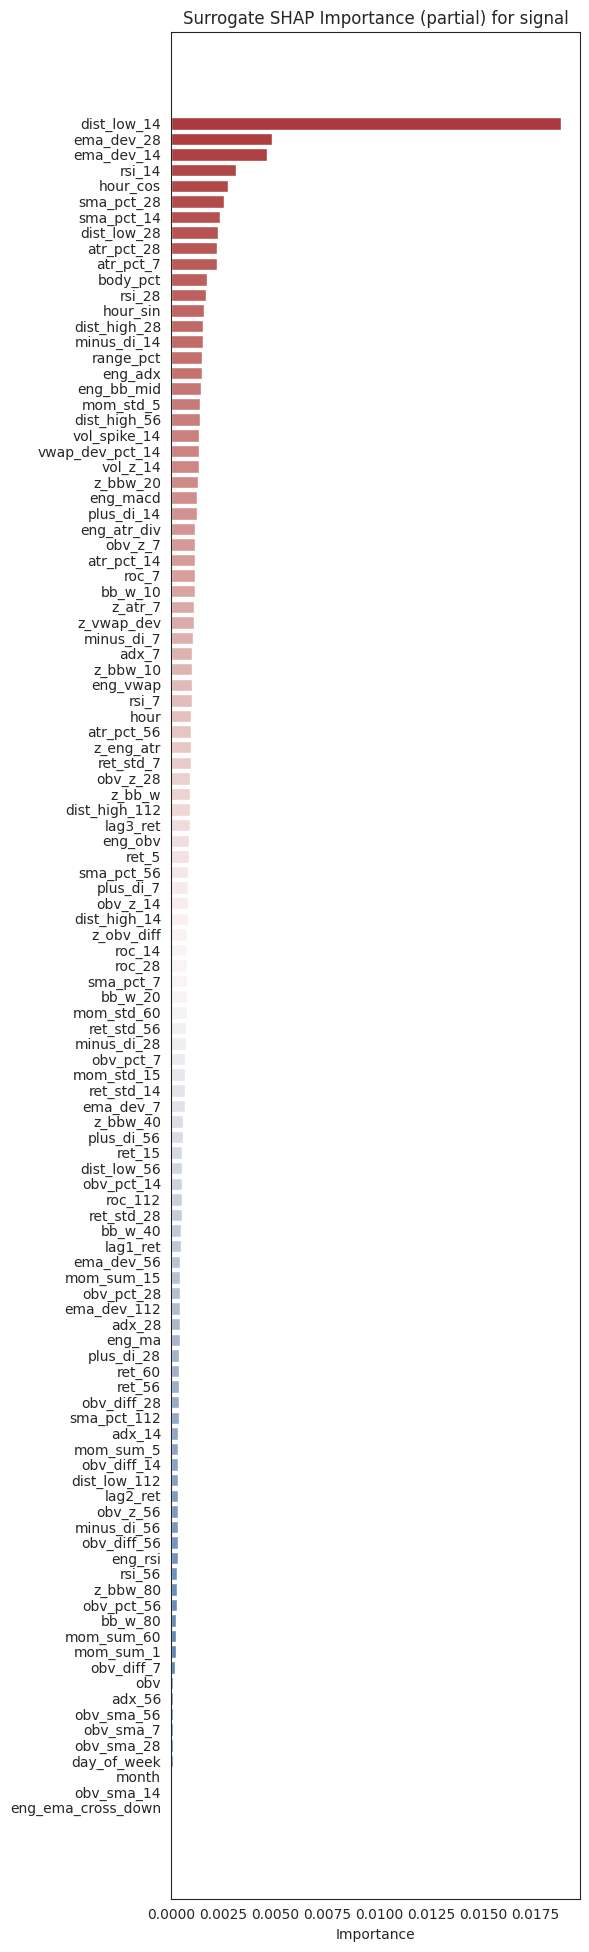

In [22]:
def surrogate_shap_importance(X_windows, y_windows, feature_names,
                                          n_samples=50, background_samples=20, batch_size=1024,
                                          seed=0, device=params.device, rf_n_estimators=30):
    """
    Surrogate SHAP using a RandomForestRegressor + TreeSHAP on flattened windows.

    - Fits RF on X_flat (N, L*F) -> y_windows (aligned per-window)
    - Uses shap.TreeExplainer on a small sampled subset and aggregates |SHAP| across timesteps to per-feature scores
    - Fast defaults: small surrogate, small explain set, chunked SHAP, and immediate UI placeholder
    - Returns (pd.Series sorted desc, None) and updates features_importances with importance_type="surrogate_shap"
    """

    rng = np.random.RandomState(seed)

    N, L, F = X_windows.shape
    assert F == len(feature_names)

    # flatten
    X_flat = X_windows.reshape(N, L * F)
    y_flat = y_windows

    # subsample for surrogate training (aggressive for speed)
    max_rows = 5000
    if X_flat.shape[0] > max_rows:
        idx_fit = rng.choice(X_flat.shape[0], size=max_rows, replace=False)
        X_fit = X_flat[idx_fit]
        y_fit = y_flat[idx_fit]
    else:
        X_fit = X_flat
        y_fit = y_flat

    # fit a small/faster RF surrogate
    rf = RandomForestRegressor(n_estimators=rf_n_estimators, max_depth=12, n_jobs=-1, random_state=seed)
    rf.fit(X_fit, y_fit)

    # immediate placeholder so UI updates quickly
    placeholder = pd.Series(np.zeros(len(feature_names)), index=feature_names)
    _ = feats.live_display_importances(placeholder, features=feature_names, label=params.label_col,
                                       method="Surrogate SHAP (training done)", batch=max(1, F//10), pause=0.01)

    # sample small explain set and explain in small chunks
    n_explain = min(n_samples, N)
    idx_exp = rng.choice(N, size=n_explain, replace=False) if N > n_explain else np.arange(N)
    X_exp_flat = X_flat[idx_exp]

    chunk = 10
    explainer = shap.TreeExplainer(rf)
    
    running_sum_feats = np.zeros((F,), dtype=np.float64)  # accumulate sum over samples+timesteps for each feature
    processed = 0
    
    for i in range(0, len(X_exp_flat), chunk):
        X_chunk = X_exp_flat[i:i+chunk]
        sv = explainer.shap_values(X_chunk)
        sv_arr = np.asarray(sv)
        if sv_arr.ndim == 3:
            sv_arr = sv_arr[0]
        # sv_arr shape: (B, L*F)
        sv_abs = np.abs(sv_arr).reshape(sv_arr.shape[0], L, F)   # (B, L, F)
        batch_sum = sv_abs.sum(axis=(0, 1)).astype(np.float64)   # (F,) sum over batch and timesteps
        running_sum_feats += batch_sum
        processed += sv_arr.shape[0]
    
        # partial live update: mean over processed samples of sum over timesteps -> (F,)
        per_feature_partial = running_sum_feats / float(processed)
        _ = feats.live_display_importances(pd.Series({feature_names[j]: float(per_feature_partial[j]) for j in range(F)}),
                                           features=feature_names, label=params.label_col,
                                           method=f"Surrogate SHAP (partial {i//chunk+1})", batch=max(1, F//10), pause=0.01)
    
    # final aggregation: mean over all explained samples of sum over timesteps
    per_feature = running_sum_feats / float(processed)

    # build series and display
    scores = {feature_names[i]: float(per_feature[i]) for i in range(F)}
    imp_series = pd.Series(scores).sort_values(ascending=False)

    _ = feats.live_display_importances(imp_series, features=imp_series.index.tolist(),
                                       label=params.label_col, method="Surrogate SHAP", batch=max(1, len(imp_series)//10), pause=0.02)

    feats.update_feature_importances(features_importances, importance_type="surrogate_shap", values=imp_series)
    return imp_series, None


##########################################################################################################################################


imp_sur_shap, _ = surrogate_shap_importance(
    X_windows, y_windows, kept_final_feats,
    n_samples=50, background_samples=20, batch_size=1024,
    seed=0, device=params.device, rf_n_estimators=30
)

feats.update_feature_importances(features_importances, importance_type="surrogate_shap", values=imp_sur_shap)


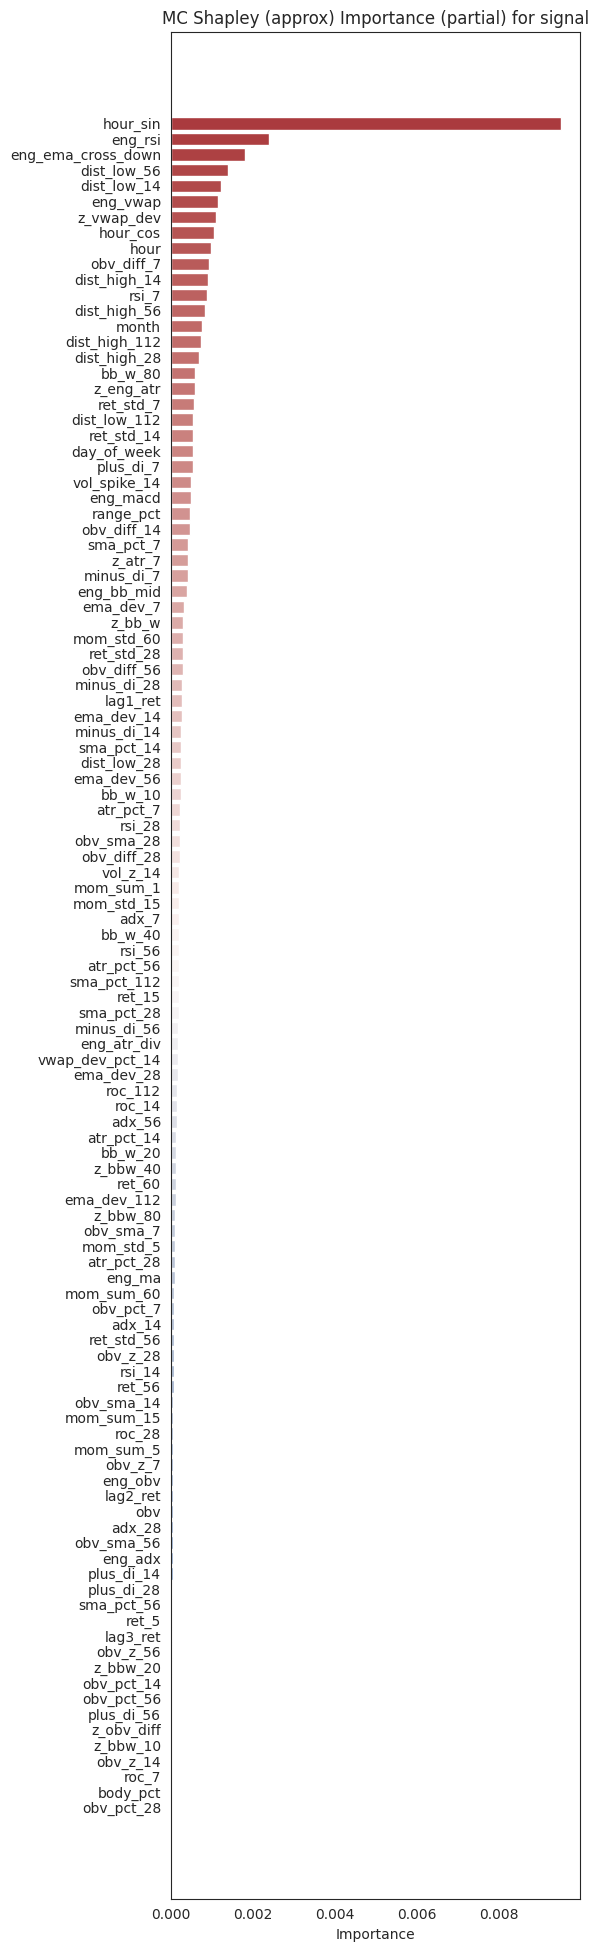

In [43]:

def model_shap_importance_mc(model, X_windows, y_windows, feature_names,
                             n_samples=200, background_samples=50, batch_size=1024,
                             seed=0, device=params.device, n_permutations=100):
    """
    Very simple Monte Carlo Shapley approximation (no shap lib, no progress bars).
    - Approximates Shapley values by sampling permutations and using a background mean to fill masked features.
    - Works on flattened (L*F) inputs by masking whole features across all timesteps.
    - Returns (pd.Series, None) and updates features_importances with importance_type="model_shap".
    Note: cheaper/faster but approximate — increase n_permutations for higher fidelity.
    """
    rng = np.random.RandomState(seed)
    N, L, F = X_windows.shape
    assert F == len(feature_names)

    # sample windows to explain
    n_explain = min(n_samples, N)
    idx_exp = rng.choice(N, size=n_explain, replace=False) if N > n_explain else np.arange(N)
    X_exp = X_windows[idx_exp].astype(np.float32, copy=False)   # (n_explain, L, F)

    # background value per feature (scalar) used when a feature is masked
    n_bg = min(background_samples, N)
    idx_bg = rng.choice(N, size=n_bg, replace=False) if N > n_bg else np.arange(N)
    X_bg = X_windows[idx_bg].astype(np.float32, copy=False)
    bg_vals = X_bg.reshape(n_bg * L, F).mean(axis=0)   # (F,)

    # baseline predictions for each explained window (no masking)
    base_preds = np.asarray(feats.predict_windows(model, X_exp, batch_size=batch_size, device=device))  # (n_explain,)

    # accumulate Shapley contributions
    shap_acc = np.zeros(F, dtype=np.float64)
    total_counts = 0

    # For each permutation sample, compute marginal contributions feature-by-feature
    for _ in range(n_permutations):
        perm = rng.permutation(F)
        # start with all features masked (filled by bg)
        X_masked = np.tile(bg_vals, (n_explain, L, 1)).astype(np.float32)  # (n_explain, L, F)
        prev_preds = np.asarray(feats.predict_windows(model, X_masked, batch_size=batch_size, device=device))

        # reveal features one by one in permutation order and record marginal gain
        for f in perm:
            # set feature f to its true values for all explained windows
            X_masked[:, :, f] = X_exp[:, :, f]
            preds = np.asarray(feats.predict_windows(model, X_masked, batch_size=batch_size, device=device))
            marginal = preds - prev_preds                            # (n_explain,)
            shap_acc[f] += marginal.sum()                            # aggregate over windows
            prev_preds = preds
        total_counts += n_explain

    # average marginal contributions per-feature across permutations and windows
    shap_values_mean = shap_acc / float(total_counts)   # expected contribution per sample

    # convert to a positive importance score (mean absolute Shapley)
    imp_scores = np.abs(shap_values_mean)
    imp_series = pd.Series({feature_names[i]: float(imp_scores[i]) for i in range(F)}).sort_values(ascending=False)

    _ = feats.live_display_importances(imp_series, features=imp_series.index.tolist(),
                                       label=params.label_col, method="MC Shapley (approx)", batch=max(1, len(imp_series)//10), pause=0.02)

    feats.update_feature_importances(features_importances, importance_type="model_shap", values=imp_series)
    return imp_series, None



##################################################################################################

imp_model_shap, _ = model_shap_importance_mc(
    model, X_windows, y_windows, kept_final_feats,
    n_samples=200, background_samples=50, batch_size=1024,
    seed=0, device=params.device, n_permutations=100
)
feats.update_feature_importances(features_importances, importance_type="model_shap", values=imp_model_shap)


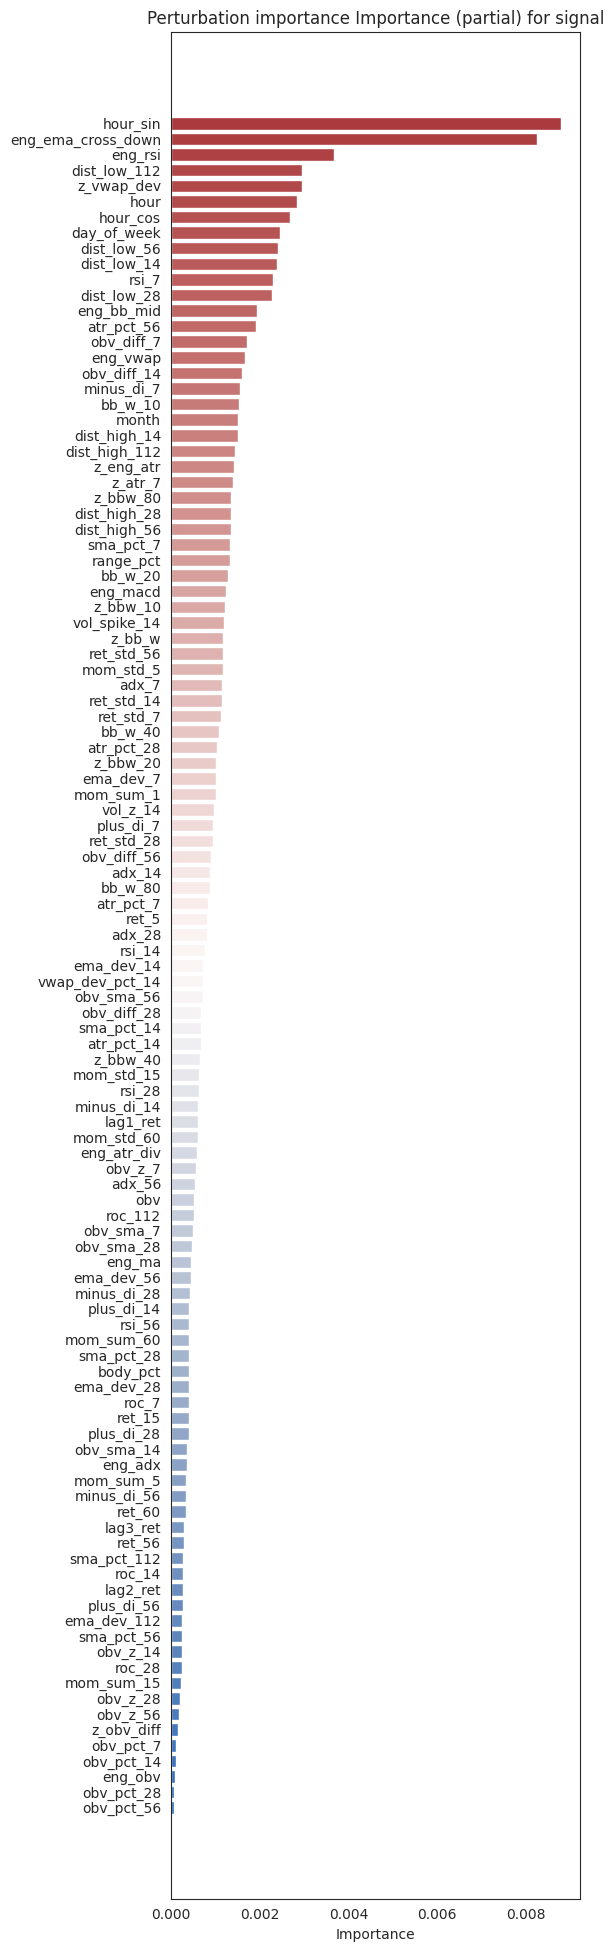

In [36]:
def model_perturbation_importance(model, X_windows, y_windows, feature_names,
                                  n_samples=500, background_samples=50, batch_size=1024,
                                  seed=0, device=params.device, **_kwargs):
    """
    Perturbation importance (no SHAP, no tqdm).
    Replaces each feature (all timesteps) with a background scalar and records
    the average absolute prediction change across sampled windows.
    Returns (pd.Series, None) and updates features_importances with importance_type="perturbation".
    """
    rng = np.random.RandomState(seed)

    N, L, F = X_windows.shape
    assert F == len(feature_names)

    # choose windows to explain
    n_explain = min(n_samples, N)
    idx_exp = rng.choice(N, size=n_explain, replace=False) if N > n_explain else np.arange(N)
    X_exp = X_windows[idx_exp].astype(np.float32, copy=False)  # (n_explain, L, F)

    # background scalar per feature: mean across background windows and timesteps
    n_bg = min(background_samples, N)
    idx_bg = rng.choice(N, size=n_bg, replace=False) if N > n_bg else np.arange(N)
    X_bg = X_windows[idx_bg].astype(np.float32, copy=False)   # (n_bg, L, F)
    bg_vals = X_bg.reshape(n_bg * L, F).mean(axis=0)  # (F,)

    # baseline predictions for sampled windows
    base_preds = feats.predict_windows(model, X_exp, batch_size=batch_size, device=device)
    base_preds = np.asarray(base_preds)

    feature_scores = np.zeros(F, dtype=np.float64)
    chunk = max(1, min(32, n_explain))

    for fi in range(F):
        deltas = []
        for i in range(0, n_explain, chunk):
            X_chunk = X_exp[i:i+chunk].copy()           # small copy (B, L, F)
            X_chunk[:, :, fi] = float(bg_vals[fi])
            preds = feats.predict_windows(model, X_chunk, batch_size=batch_size, device=device)
            preds = np.asarray(preds)
            base_slice = base_preds[i:i+len(preds)]
            deltas.append(np.abs(base_slice - preds))
        all_deltas = np.concatenate(deltas, axis=0)
        feature_scores[fi] = float(all_deltas.mean())

        # occasional partial UI update
        if (fi + 1) % 5 == 0 or fi == F - 1:
            partial_series = pd.Series({feature_names[j]: float(feature_scores[j]) for j in range(F)}).sort_values(ascending=False)
            _ = feats.live_display_importances(partial_series, features=feature_names, label=params.label_col, method="Perturbation importance (partial)", batch=8, pause=0.02)

    imp_series = pd.Series({feature_names[i]: feature_scores[i] for i in range(F)}).sort_values(ascending=False)
    _ = feats.live_display_importances(imp_series, features=imp_series.index.tolist(), label=params.label_col, method="Perturbation importance", batch=max(1, len(imp_series)//10), pause=0.02)

    feats.update_feature_importances(features_importances, importance_type="perturbation", values=imp_series)
    return imp_series, None



##########################################################################################################################################


# perturbation proxy (fast, quiet)
imp_perturb, _ = model_perturbation_importance(
    model, X_windows, y_windows, kept_final_feats,
    n_samples=500, background_samples=50, batch_size=1024, seed=0, device=params.device
)
feats.update_feature_importances(features_importances, importance_type="perturbation", values=imp_perturb)


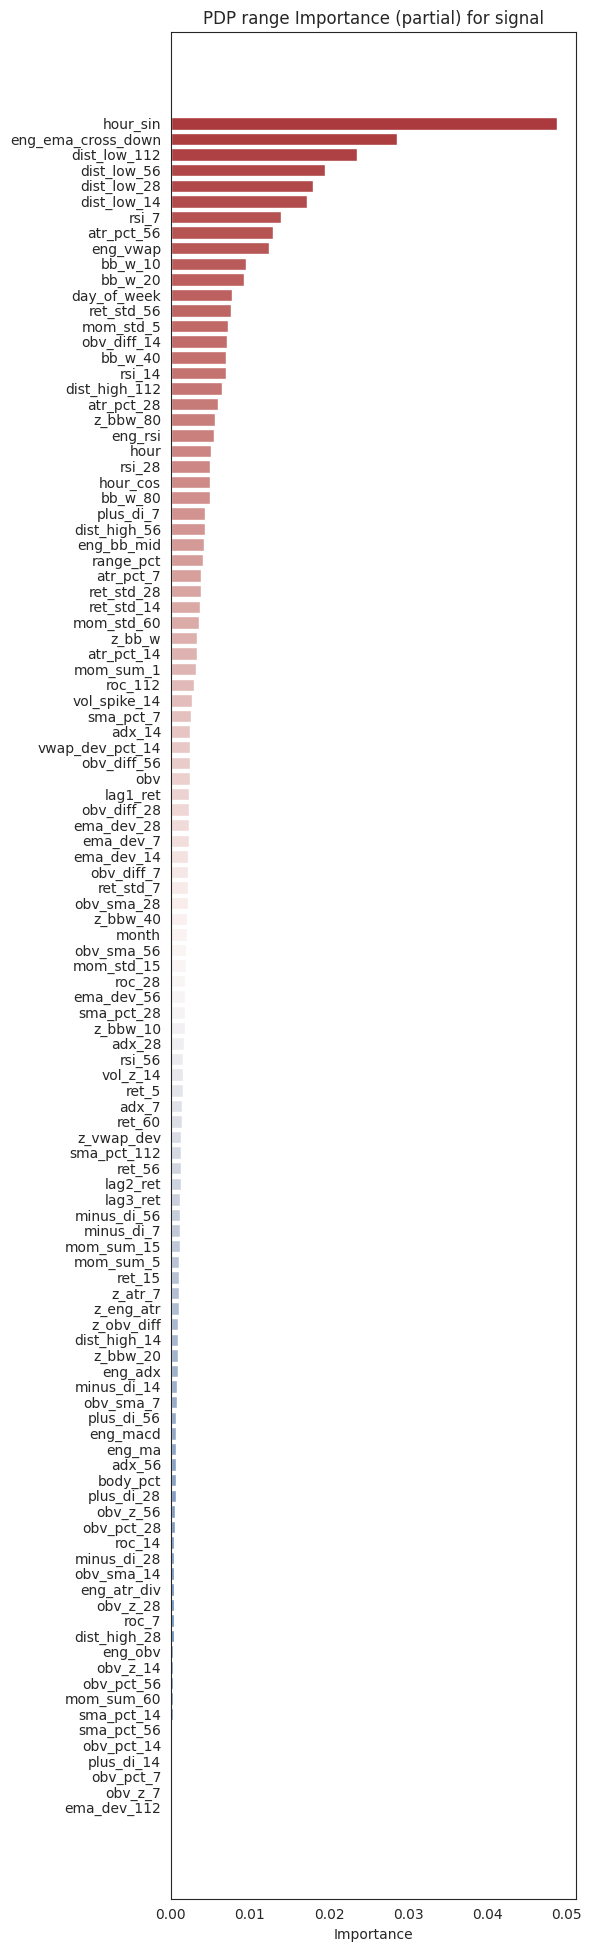

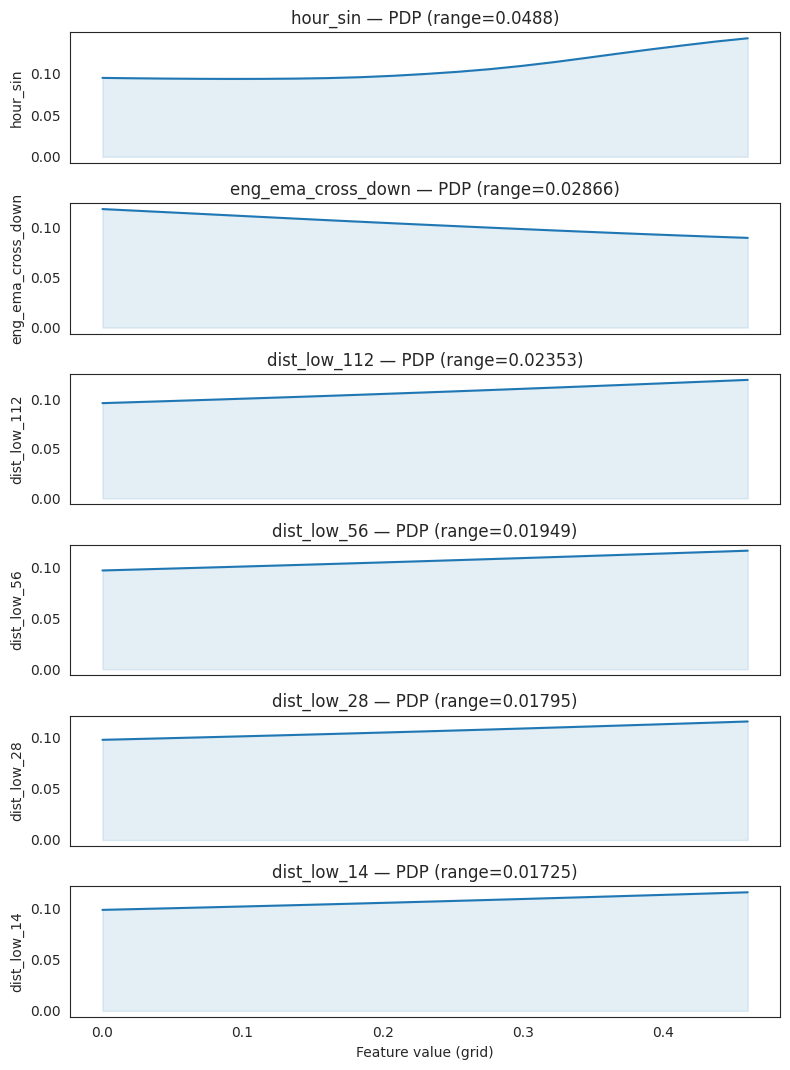

In [30]:
def pdp_ice_ale_importance(model, X_windows, y_windows, feature_names,
                                       grid_size=21, sample_size=500, method="pdp",
                                       plot=True, figsize=(8, None), cmap="vlag",
                                       seed=0, batch_size=1024, device=params.device):
    """
    Partial Dependence (PDP) / ICE / simple ALE style summary for windowed features.

    - method: "pdp" (average prediction vs feature value) or "ice" (plot a small set of individual curves).
    - grid_size: number of points in the feature value grid (per feature).
    - sample_size: how many windows to sample for ICE/pdp computation (for speed).
    - Returns (pd.Series sorted desc by PDP range, None) and updates features_importances with importance_type="pdp".
    - Notes:
      * For windowed inputs we collapse the time axis by replacing every timestep of the chosen feature
        with the grid value for each sample when evaluating the model. This gives a per-feature marginal effect
        as the model sees it across the whole window.
      * Importance is defined as the range (max-min) of the PDP curve (larger range -> more effect).
    """

    rng = np.random.RandomState(seed)

    N, L, F = X_windows.shape
    assert F == len(feature_names)

    # sample rows to evaluate to reduce cost
    n_eval = min(sample_size, N)
    if N > n_eval:
        idx_eval = rng.choice(N, size=n_eval, replace=False)
    else:
        idx_eval = np.arange(N)
    X_eval = X_windows[idx_eval].astype(np.float32, copy=False)  # (n_eval, L, F)

    # collect per-feature PDP curves and importance (range)
    pdp_curves = {}
    ranges = np.zeros(F, dtype=float)

    # precompute observed values for each feature across all windows and timesteps to build grid
    feat_vals = X_windows.reshape(N * L, F)

    for fi, fname in enumerate(feature_names):
        vals = feat_vals[:, fi]
        lo, hi = np.percentile(vals, [1, 99])
        if lo == hi:
            # degenerate: create tiny interval
            lo = vals.min()
            hi = vals.max() if vals.max() != lo else lo + 1e-6
        grid = np.linspace(lo, hi, grid_size)

        preds_grid = []
        # evaluate model at each grid point by replacing feature fi across all timesteps with grid value
        for g in grid:
            orig_col = X_eval[:, :, fi].copy()        # small (n_eval, L)
            X_eval[:, :, fi] = g                      # in-place set
            with torch.no_grad():
                p = feats.predict_windows(model, X_eval, batch_size=batch_size, device=device)
            preds_grid.append(p.mean())
            X_eval[:, :, fi] = orig_col               # restore

        preds_grid = np.array(preds_grid)  # shape (grid_size,)

        pdp_curves[fname] = (grid, preds_grid)
        ranges[fi] = float(preds_grid.max() - preds_grid.min())

        # occasional partial UI reveal for speed/feedback every few features
        if (fi + 1) % 5 == 0 or fi == F - 1:
            partial_scores = pd.Series({feature_names[j]: float(ranges[j]) for j in range(F)}).sort_values(ascending=False)
            _ = feats.live_display_importances(partial_scores, features=feature_names, label=params.label_col, method="PDP range (partial)", batch=8, pause=0.02)

    # build importance series (range of PDP) and sort
    scores = {feature_names[i]: float(ranges[i]) for i in range(F)}
    imp_series = pd.Series(scores).sort_values(ascending=False)

    # final reveal
    _ = feats.live_display_importances(imp_series, features=imp_series.index.tolist(), label=params.label_col, method="PDP range", batch=8, pause=0.02)

    # update stored importances
    feats.update_feature_importances(features_importances, importance_type="pdp", values=imp_series)

    # plotting: show PDP curves for top K features (or ICE if requested)
    if plot:
        topk = min(6, F)
        top_feats = imp_series.index.tolist()[:topk]
        height = figsize[1] if figsize[1] is not None else max(3, topk * 1.8)
        plt.figure(figsize=(figsize[0], height))
        for i, fname in enumerate(top_feats):
            grid, preds_grid = pdp_curves[fname]
            ax = plt.subplot(topk, 1, i + 1)
            if method == "ice":
                # ICE: plot a few individual sample curves instead of PDP
                # choose up to 20 samples to show
                n_ice = min(20, len(idx_eval))
                ice_idx = np.arange(n_ice)
                for j in ice_idx:
                    ice_preds = []
                    for g in grid:
                        Xp = X_eval.copy()
                        Xp[j, :, feature_names.index(fname) if False else feature_names.index(fname)] = g
                        # the above line uses fname index; simpler reuse fi mapping:
                        # but here we have fi in outer loop not available; instead compute index
                        pass
                # fallback to PDP if ICE not implemented per-sample to keep function compact
                ax.plot(grid, preds_grid, color="C0")
                ax.set_ylabel(fname)
            else:
                ax.plot(grid, preds_grid, color="C0")
                ax.fill_between(grid, preds_grid, alpha=0.12, color="C0")
                ax.set_ylabel(fname)
            if i == topk - 1:
                ax.set_xlabel("Feature value (grid)")
            else:
                ax.set_xticks([])
            ax.set_title(f"{fname} — PDP (range={ranges[feature_names.index(fname)]:.4g})")
        plt.tight_layout()
        plt.show()

    return imp_series, None


##########################################################################################################################################


imp_pdp, _ = pdp_ice_ale_importance(
    model, X_windows, y_windows, kept_final_feats,
    grid_size=21, sample_size=300, method="pdp",
    plot=True, figsize=(8, None), cmap="vlag",
    seed=0, batch_size=1024, device=params.device
)

feats.update_feature_importances(features_importances, importance_type="pdp", values=imp_pdp)


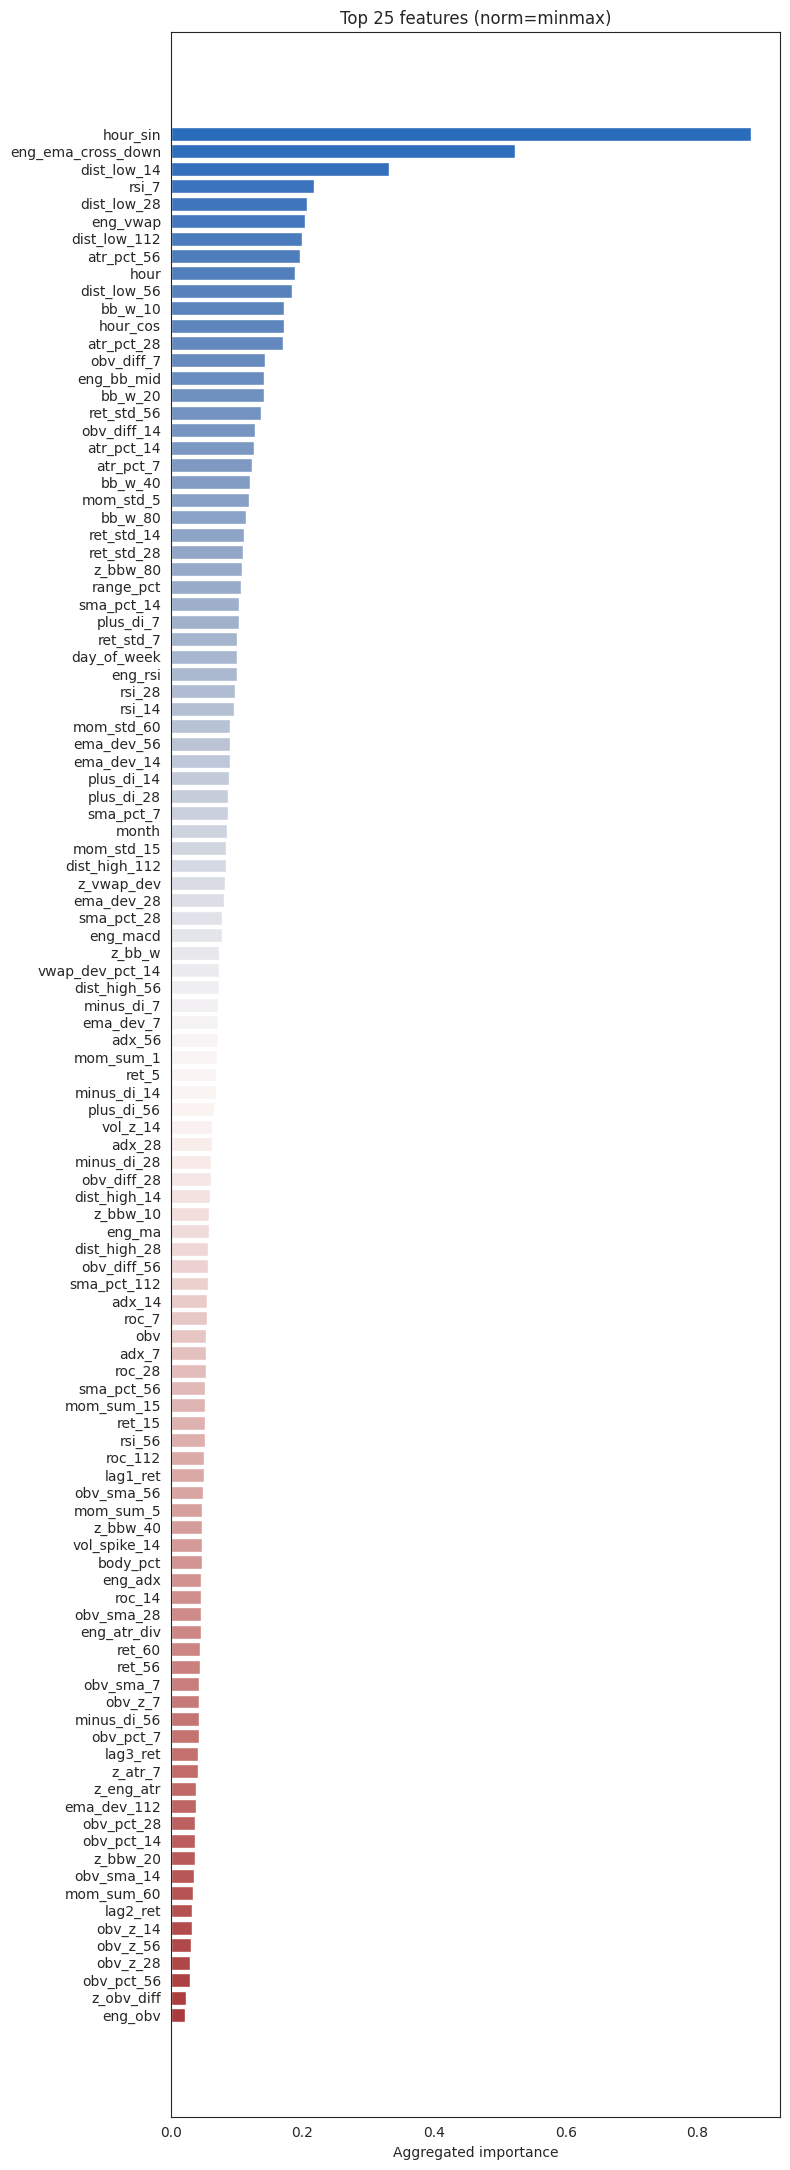

['hour_sin', 'eng_ema_cross_down', 'dist_low_14', 'rsi_7', 'dist_low_28', 'eng_vwap', 'dist_low_112', 'atr_pct_56', 'hour', 'dist_low_56', 'bb_w_10', 'hour_cos', 'atr_pct_28', 'obv_diff_7', 'eng_bb_mid', 'bb_w_20', 'ret_std_56', 'obv_diff_14', 'atr_pct_14', 'atr_pct_7', 'bb_w_40', 'mom_std_5', 'bb_w_80', 'ret_std_14', 'ret_std_28']


,ablation,corr,ig,linreg,mi,model_shap,pdp,perm,surrogate_shap,avg_raw,avg_positive,ablation_norm,corr_norm,ig_norm,linreg_norm,mi_norm,model_shap_norm,pdp_norm,perm_norm,surrogate_shap_norm
hour_sin,1.430148e-04,0.182179,0.094155,0.014306,0.045599,0.008783,0.048796,4.295284e-04,0.001608,0.044000,0.881468,1.000000,0.709107,1.000000,0.279991,0.903247,1.000000,1.000000,1.000000,0.085898
eng_ema_cross_down,8.703489e-05,0.088501,0.013117,0.000738,0.020803,0.008255,0.028656,2.668674e-04,0.000017,0.017827,0.523055,0.608572,0.344479,0.139313,0.014451,0.412080,0.939844,0.587264,0.621303,0.000905
dist_low_14,4.521105e-05,0.208940,0.004606,0.003155,0.025688,0.002401,0.017245,6.336471e-05,0.018715,0.031207,0.331316,0.316128,0.813270,0.048921,0.061755,0.508842,0.273425,0.353418,0.147522,1.000000
rsi_7,4.182104e-05,0.112152,0.016369,0.003102,0.011090,0.002312,0.013946,5.650055e-05,0.001000,0.017785,0.217837,0.292425,0.436536,0.173849,0.060719,0.219669,0.263222,0.285802,0.131541,0.053422
dist_low_28,8.496922e-06,0.209955,0.005451,0.003704,0.023618,0.002277,0.017948,3.179861e-05,0.002284,0.029475,0.207436,0.059413,0.817220,0.057897,0.072495,0.467825,0.259309,0.367816,0.074031,0.122056
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
obv_z_56,1.727603e-07,0.051361,0.007712,0.000753,0.010347,0.000181,0.000538,4.412917e-07,0.000340,0.007915,0.030754,0.001208,0.199917,0.081908,0.014736,0.204956,0.020567,0.011031,0.001027,0.018181
obv_z_28,-2.284534e-06,0.061597,0.004554,0.001941,0.005336,0.000203,0.000356,-2.200871e-06,0.000935,0.008324,0.029723,0.000000,0.239757,0.048362,0.037985,0.105692,0.023090,0.007286,0.000000,0.049958
obv_pct_56,1.105014e-06,0.034730,0.001047,0.002497,0.020868,0.000069,0.000280,8.597660e-07,0.000280,0.006641,0.028510,0.007727,0.135181,0.011116,0.048880,0.413359,0.007839,0.005745,0.002002,0.014954
z_obv_diff,3.590249e-07,0.004617,0.008740,0.001430,0.006574,0.000160,0.000886,-1.500982e-07,0.000800,0.002579,0.022842,0.002510,0.017971,0.092823,0.027997,0.130220,0.018194,0.018162,0.000000,0.042734


In [31]:
def normalized_avg_positive_and_plot(feat_dict,
                                   method_norm="minmax",
                                   weights=None,
                                   top_n=15,
                                   plot=True,
                                   figsize=(12, None),
                                   cmap="vlag",
                                   signed_methods=None):
    """
    Compact aggregator: expects feat_dict = {feature: {method: value, ...}, ...}.
    Returns (df, top_features) where df is tidy and top_features is a list of top_n features by avg_positive.
    Supports method_norm in {"minmax","zscore","rank","pct"} and optional signed_methods (take abs before norm).
    """

    if signed_methods is None:
        signed_methods = []

    # canonical methods and feature-frame
    methods = sorted({k for v in feat_dict.values() if isinstance(v, dict) for k in v.keys()})
    if not methods:
        raise ValueError("feat_dict must contain inner dicts with method keys")
    df = pd.DataFrame.from_dict(feat_dict, orient="index").reindex(columns=methods).astype(float).fillna(0.0)

    # avg_raw
    df["avg_raw"] = df[methods].mean(axis=1)

    # prepare magnitudes for normalization
    x = df[methods].copy()
    for m in signed_methods:
        if m in x.columns:
            x[m] = x[m].abs()
    x = x.clip(lower=0.0)

    # normalize
    if method_norm == "minmax":
        norm = x.divide(x.max(axis=0).replace(0, 1), axis=1)
    elif method_norm == "zscore":
        mu = x.mean(axis=0); sd = x.std(axis=0).replace(0, 1)
        z = (x - mu) / sd
        z = z.clip(lower=0.0)
        norm = z.divide(z.max(axis=0).replace(0, 1), axis=1)
    elif method_norm == "rank":
        ranks = x.rank(method="average", ascending=True)
        denom = (ranks.max() - ranks.min()).replace(0, 1)
        norm = (ranks - ranks.min()) / denom
    elif method_norm == "pct":
        norm = x.apply(lambda col: np.array([stats.percentileofscore(col.values, v, kind="weak") / 100.0 for v in col.values]), axis=0)
        norm = pd.DataFrame(norm.tolist(), index=x.index, columns=x.columns)
    else:
        raise ValueError("method_norm must be one of {'minmax','zscore','rank','pct'}")

    # weights (aligned)
    if weights:
        w = pd.Series(weights).reindex(methods).fillna(0.0).astype(float)
        w = w / (w.sum() if w.sum() > 0 else 1.0)
    else:
        w = pd.Series(1.0 / len(methods), index=methods)

    # aggregated score
    df["avg_positive"] = (norm * w).sum(axis=1)

    # add normalized columns (short form)
    for m in methods:
        df[f"{m}_norm"] = norm[m]

    # sort and top list
    df = df.sort_values("avg_positive", ascending=False)
    top_features = df.index[:max(0, int(top_n))].tolist()

    # plot
    if plot:
        n = len(df)
        height = figsize[1] if figsize[1] is not None else max(3, n * 0.2)
        plt.figure(figsize=(figsize[0], height))
        try:
            colors = sns.color_palette(cmap, n)
        except Exception:
            colors = sns.color_palette("vlag", n)
        plt.barh(df.index.astype(str), df["avg_positive"], color=colors)
        plt.gca().invert_yaxis()
        plt.xlabel("Aggregated importance")
        plt.title(f"Top {len(top_features)} features (norm={method_norm})")
        plt.tight_layout()
        plt.show()

    return df, top_features


#####################################################################

signed_methods = ["ig", "surrogate_shap", "shap"]

weights = {
  "perm": 0.22,
  "pdp": 0.18,
  "ablation": 0.15,
  "model_shap": 0.12,
  "surrogate_shap": 0.07,
  "shap": 0.07,
  "ig": 0.07,
  "linreg": 0.04,
  "corr": 0.05,
  "mi": 0.03
}

report, top_features = normalized_avg_positive_and_plot(
    features_importances,
    method_norm="minmax",
    weights=weights,
    top_n=25,
    plot=True,
    figsize=(8, None),
    cmap="vlag",
    signed_methods=signed_methods
)
print(top_features)
report


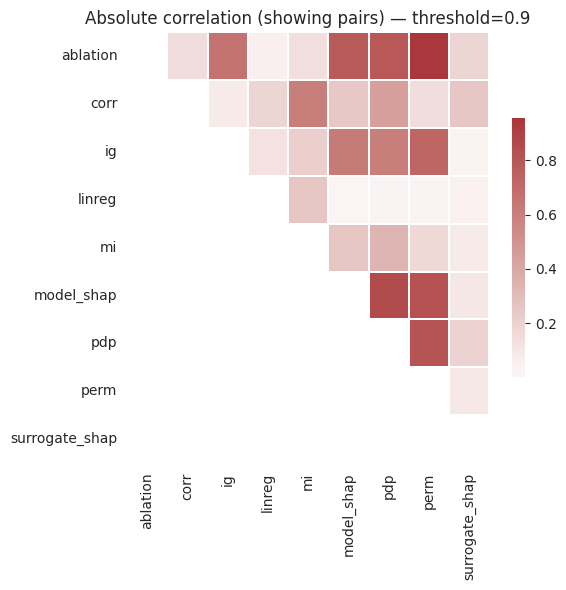

Norm columns used: ['ablation', 'corr', 'ig', 'linreg', 'mi', 'model_shap', 'pdp', 'perm', 'surrogate_shap']
High-correlation pairs: [('ablation', 'perm')]


In [32]:
def correlation_screen_from_report(report: pd.DataFrame,
                                   threshold: float = 0.9,
                                   plot: bool = True,
                                   strip_suffix: bool = True) -> tuple[pd.DataFrame, list[tuple[str,str]]]:
    """
    Extract columns ending with '_norm' from `report`, compute absolute correlations,
    plot an upper-triangle heatmap (optional), and return (fi_df, high_corr_pairs).

    - report: DataFrame (rows = features, columns include '<method>_norm' columns)
    - threshold: absolute-correlation threshold to flag pairs
    - plot: whether to show heatmap
    - strip_suffix: if True, drop the trailing '_norm' in row/col labels in the plot and output
    """

    # 1. pick normalized columns
    norm_cols = [c for c in report.columns if c.endswith("_norm")]
    if not norm_cols:
        raise ValueError("No columns ending with '_norm' found in report")

    fi_df = report[norm_cols].copy()

    # optionally rename columns to remove suffix for nicer labels
    if strip_suffix:
        fi_df = fi_df.rename(columns={c: c[:-5] for c in norm_cols})  # drop '_norm'

    # 2. correlation matrix (absolute)
    corr = fi_df.corr().abs()

    # 3. mask upper triangle if plotting (we'll show upper triangle only)
    mask = np.triu(np.ones_like(corr, dtype=bool), k=1)

    # 4. optional plot
    if plot:
        plt.figure(figsize=(max(6, corr.shape[0]*0.25), max(6, corr.shape[0]*0.25)))
        sns.heatmap(corr, mask=~mask, cmap="vlag", center=0, square=False,
                    linewidths=0.3, cbar_kws={"shrink": 0.6})
        plt.title(f"Absolute correlation (showing pairs) — threshold={threshold}")
        plt.tight_layout()
        plt.show()

    # 5. find high-correlation pairs (use mask to avoid duplicates and self-pairs)
    high_corr = []
    # iterate over upper triangle indices
    rows, cols = np.where((corr.values > threshold) & np.triu(np.ones_like(corr.values, dtype=bool), k=1))
    for r, c in zip(rows, cols):
        high_corr.append((corr.index[r], corr.columns[c]))

    return fi_df, high_corr

######################

fi_df, high_pairs = correlation_screen_from_report(report, threshold=0.9, plot=True)
print("Norm columns used:", fi_df.columns.tolist())
print("High-correlation pairs:", high_pairs)


In [33]:
def compute_vif(fi_df: pd.DataFrame,
                thresh: float = 10.0,
                verbose: bool = True) -> pd.DataFrame:
    """
    Compute VIF for columns in fi_df (expects fi_df to already contain the predictor columns,
    e.g., the normalized '<method>_norm' columns or a subset you want to analyze).

    Returns a DataFrame with columns: feature, VIF, flag (True if VIF > thresh).
    - Fills NaNs -> 0, keeps only numeric non-constant columns, and computes VIF using statsmodels.
    - If fewer than 2 features remain, returns VIF=0 for available features and issues a message.
    """

    # 1) defensive copy and fill missing
    X = fi_df.copy().fillna(0.0)

    # 2) keep numeric columns only
    X = X.select_dtypes(include=[np.number])
    if X.shape[1] == 0:
        raise ValueError("fi_df contains no numeric columns to compute VIF")

    # 3) drop constant columns (zero variance)
    variances = X.var(axis=0)
    keep_cols = variances[variances > 0.0].index.tolist()
    X = X[keep_cols]

    if X.shape[1] < 2:
        if verbose:
            print("Less than 2 non-constant numeric features → VIF not meaningful.")
        return pd.DataFrame({
            "feature": X.columns.tolist(),
            "VIF": [0.0] * len(X.columns),
            "flag": [False] * len(X.columns)
        })

    # 4) add intercept and compute VIF for each feature (skip intercept at pos 0)
    Xc = add_constant(X, has_constant="add")
    records = []
    for i, feat in enumerate(X.columns, start=1):
        try:
            v = float(variance_inflation_factor(Xc.values, i))
        except Exception as e:
            if verbose:
                print(f"Could not compute VIF for {feat}: {e}")
            v = float("nan")
        records.append({
            "feature": feat,
            "VIF": v,
            "flag": bool(np.isfinite(v) and v > thresh)
        })

    vif_df = pd.DataFrame(records).sort_values("VIF", ascending=False).reset_index(drop=True)
    return vif_df


##################

# fi_df is the DataFrame you obtained from extracting normalized columns (rows = observations, cols = predictors)
vif_df = compute_vif(fi_df, thresh=10.0, verbose=True)
vif_df



,feature,VIF,flag
0,perm,18.306402,True
1,ablation,13.064280,True
2,pdp,6.418603,False
3,model_shap,4.702875,False
4,ig,2.373763,False
5,corr,2.268174,False
6,mi,1.755292,False
7,surrogate_shap,1.210349,False
8,linreg,1.167934,False


In [34]:
print(top_features)

['hour_sin', 'eng_ema_cross_down', 'dist_low_14', 'rsi_7', 'dist_low_28', 'eng_vwap', 'dist_low_112', 'atr_pct_56', 'hour', 'dist_low_56', 'bb_w_10', 'hour_cos', 'atr_pct_28', 'obv_diff_7', 'eng_bb_mid', 'bb_w_20', 'ret_std_56', 'obv_diff_14', 'atr_pct_14', 'atr_pct_7', 'bb_w_40', 'mom_std_5', 'bb_w_80', 'ret_std_14', 'ret_std_28']


In [35]:
imp_model_shap.index

Index(['hour_sin', 'eng_ema_cross_down', 'eng_rsi', 'dist_low_112',
       'z_vwap_dev', 'hour', 'hour_cos', 'day_of_week', 'dist_low_56',
       'dist_low_14',
       ...
       'roc_28', 'mom_sum_15', 'obv_z_28', 'obv_z_56', 'z_obv_diff',
       'obv_pct_7', 'obv_pct_14', 'eng_obv', 'obv_pct_28', 'obv_pct_56'],
      dtype='object', length=109)